<a href="https://colab.research.google.com/github/leonyangucl/2023fyp/blob/main/PD_inpainting2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import random
import nibabel as nib
from tqdm import tqdm

##Read the data

In [3]:

#pCASL
img_pCASL = nib.load('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED/21174/ASL/pCASL_data.nii.gz')
#PD_cal
img_PD_cal = nib.load('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED/21174/ASL/PD_cal.nii.gz')
#PWI_corr
img_PWI_corr = nib.load('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED/21174/ASL/PWI_corr.nii.gz')
#ROI_hd
img_ROI_hd = nib.load('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED/21174/T1/ROI_hd.nii.gz')
#T1_brain_hd
img_T1_brain_hd = nib.load('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED/21174/T1/T1_brain_hd.nii.gz')


In [4]:
data_pCASL = img_pCASL.get_fdata()
data_PD_cal = img_PD_cal.get_fdata()
data_PWI_corr = img_PWI_corr.get_fdata()
data_ROI_hd = img_ROI_hd.get_fdata()
data_T1_brain_hd = img_T1_brain_hd.get_fdata()


print(data_pCASL.shape)
print(data_PD_cal.shape)
print(data_PWI_corr.shape)
print(data_ROI_hd.shape)
print(data_T1_brain_hd.shape)

(80, 80, 20, 70)
(80, 80, 20, 3)
(80, 80, 20)
(192, 256, 192)
(192, 256, 192)


In [5]:
# #old method
# #all slices
# import os
# import nibabel as nib
# import numpy as np

# dir_path = '/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED'

# all_data = []

# for folder_name in os.listdir(dir_path):
#     file_path = os.path.join(dir_path, folder_name, 'ASL','PD_cal.nii.gz')
#     if os.path.exists(file_path):
#         img = nib.load(file_path)
#         data = img.get_fdata()
#         for i in range(data.shape[-1]):
#             for j in range(data.shape[-2]):
#                 slice_data = data[..., j, i]
#                 # normalization for each slice
#                 min_val = np.min(slice_data)
#                 max_val = np.max(slice_data)
#                 norm_data = (slice_data - min_val) / (max_val - min_val) if max_val > min_val else slice_data
#                 all_data.append(norm_data)

# dataset = np.stack(all_data)


In [6]:
import os
import nibabel as nib
import numpy as np

dir_path = '/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED'

all_data = []

for folder_name in os.listdir(dir_path):
    file_path = os.path.join(dir_path, folder_name, 'ASL','PD_cal.nii.gz')
    if os.path.exists(file_path):
        img = nib.load(file_path)
        data = img.get_fdata()
        for i in range(data.shape[-1]):
            for j in range(8, 18):
                slice_data = data[..., j, i]
                # normalization for each slice
                min_val = np.min(slice_data)
                max_val = np.max(slice_data)
                norm_data = (slice_data - min_val) / (max_val - min_val) if max_val > min_val else slice_data
                all_data.append(norm_data)

dataset = np.stack(all_data)


In [7]:
dataset.shape

(1710, 80, 80)

In [8]:
max_val=np.max(dataset[15,:,:])
max_val

1.0

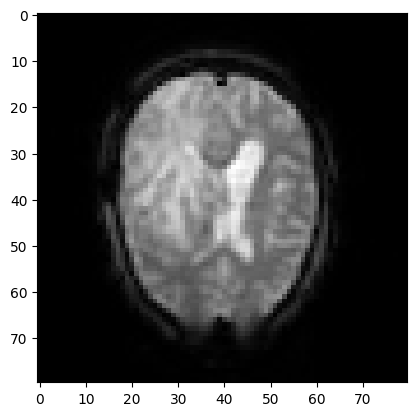

In [9]:
plt.imshow(dataset[15,:,:].T,cmap='gray')
plt.show()

##Image cropping

In [10]:
import numpy as np
from tqdm import tqdm



def random_crop(data, crop_size=(32, 32), min_nonzero_ratio=4/5, crops_per_image=5, threshold=1e-02):
    cropped_data = []
    for img in tqdm(data,desc='Cropping images'):
        crop_counter = 0
        while crop_counter < crops_per_image:
            # we randomly chosse the starting point of cropping
            start_x = np.random.randint(0, img.shape[1] - crop_size[0] + 1)
            start_y = np.random.randint(0, img.shape[0] - crop_size[1] + 1)

            # crop the image
            cropped = img[start_y:start_y + crop_size[1], start_x:start_x + crop_size[0]]

            # check whether threshold is satisfied
            if np.count_nonzero(cropped > threshold) / (crop_size[0] * crop_size[1]) >= min_nonzero_ratio:
                cropped_data.append(cropped)
                crop_counter += 1

    return np.array(cropped_data)

cropped_data = random_crop(dataset)


Cropping images: 100%|██████████| 1710/1710 [00:00<00:00, 5354.91it/s]


The shape of cropped data

In [11]:
cropped_data.shape

(8550, 32, 32)

Some examples of the cropped data

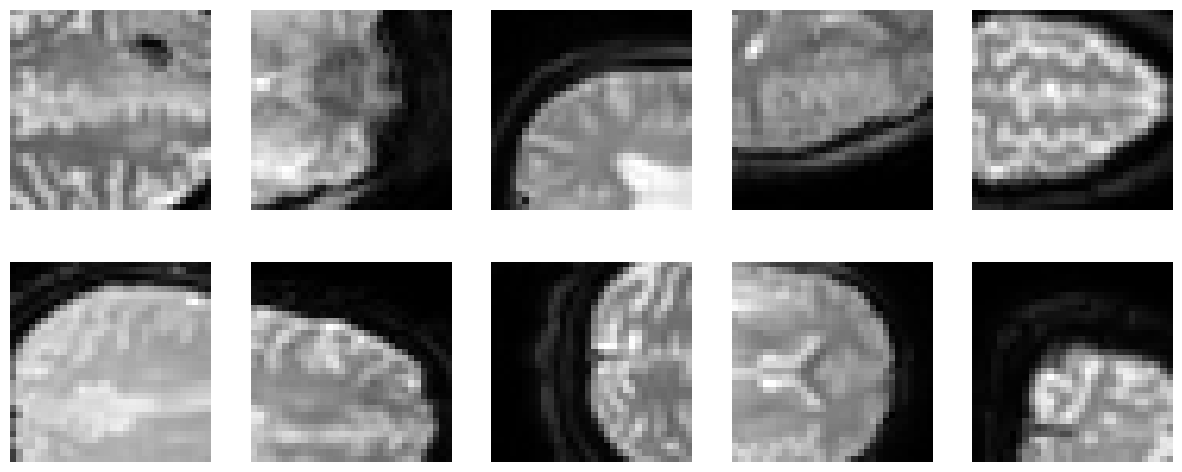

In [12]:
import matplotlib.pyplot as plt


indices = np.random.choice(len(cropped_data), size=10, replace=False)


fig, axes = plt.subplots(2, 5, figsize=(15, 6))


for ax, idx in zip(axes.flatten(), indices):
    ax.imshow(cropped_data[idx], cmap='gray')
    ax.axis('off')
plt.show()


##Image masking

In [13]:
## old method
# from skimage.draw import random_shapes
# import numpy as np


# image_shape = (32, 32)
# max_shapes = 1
# min_size = 15
# max_size = 28
# shape = 'circle'


# new_dataset = []
# labels = []

# for image in cropped_data:
#     for _ in range(5):
#         # generate masks
#         mask, _ = random_shapes(image_shape, max_shapes=max_shapes,
#                                 min_size=min_size, max_size=max_size,
#                                 channel_axis=None, shape=shape)

#         # apply mask to the images
#         mask = (mask == 255).astype(float)
#         image_masked = np.where(mask == 0, 0, image)


#         new_dataset.append(image_masked)
#         labels.append(image)

# # change to numpy
# new_dataset = np.stack(new_dataset)
# labels = np.stack(labels)

# print('data shape', new_dataset.shape)
# print('label shape', labels.shape)


In [14]:
#new method (also saving the mask)
#mask image

from skimage.draw import random_shapes
import numpy as np


image_shape = (32, 32)
max_shapes = 1
min_size = 18
max_size = 25
shape = 'circle'

new_dataset = []
labels = []
masks = []

for image in tqdm(cropped_data):
    for _ in range(5):
        # generate masks
        mask, _ = random_shapes(image_shape, max_shapes=max_shapes,
                                min_size=min_size, max_size=max_size,
                                channel_axis=None, shape=shape)

        # apply mask to the images
        mask = (mask == 255).astype(float)
        image_masked = np.where(mask == 0, 0, image)


        new_dataset.append(image_masked)
        labels.append(image)
        masks.append(mask)

# change to numpy array
new_dataset = np.stack(new_dataset)
labels = np.stack(labels)
masks = np.stack(masks)

print('data shape', new_dataset.shape)
print('label shape', labels.shape)
print('mask shape', masks.shape)


100%|██████████| 8550/8550 [00:20<00:00, 419.97it/s]


data shape (42750, 32, 32)
label shape (42750, 32, 32)
mask shape (42750, 32, 32)


Examples of masked data

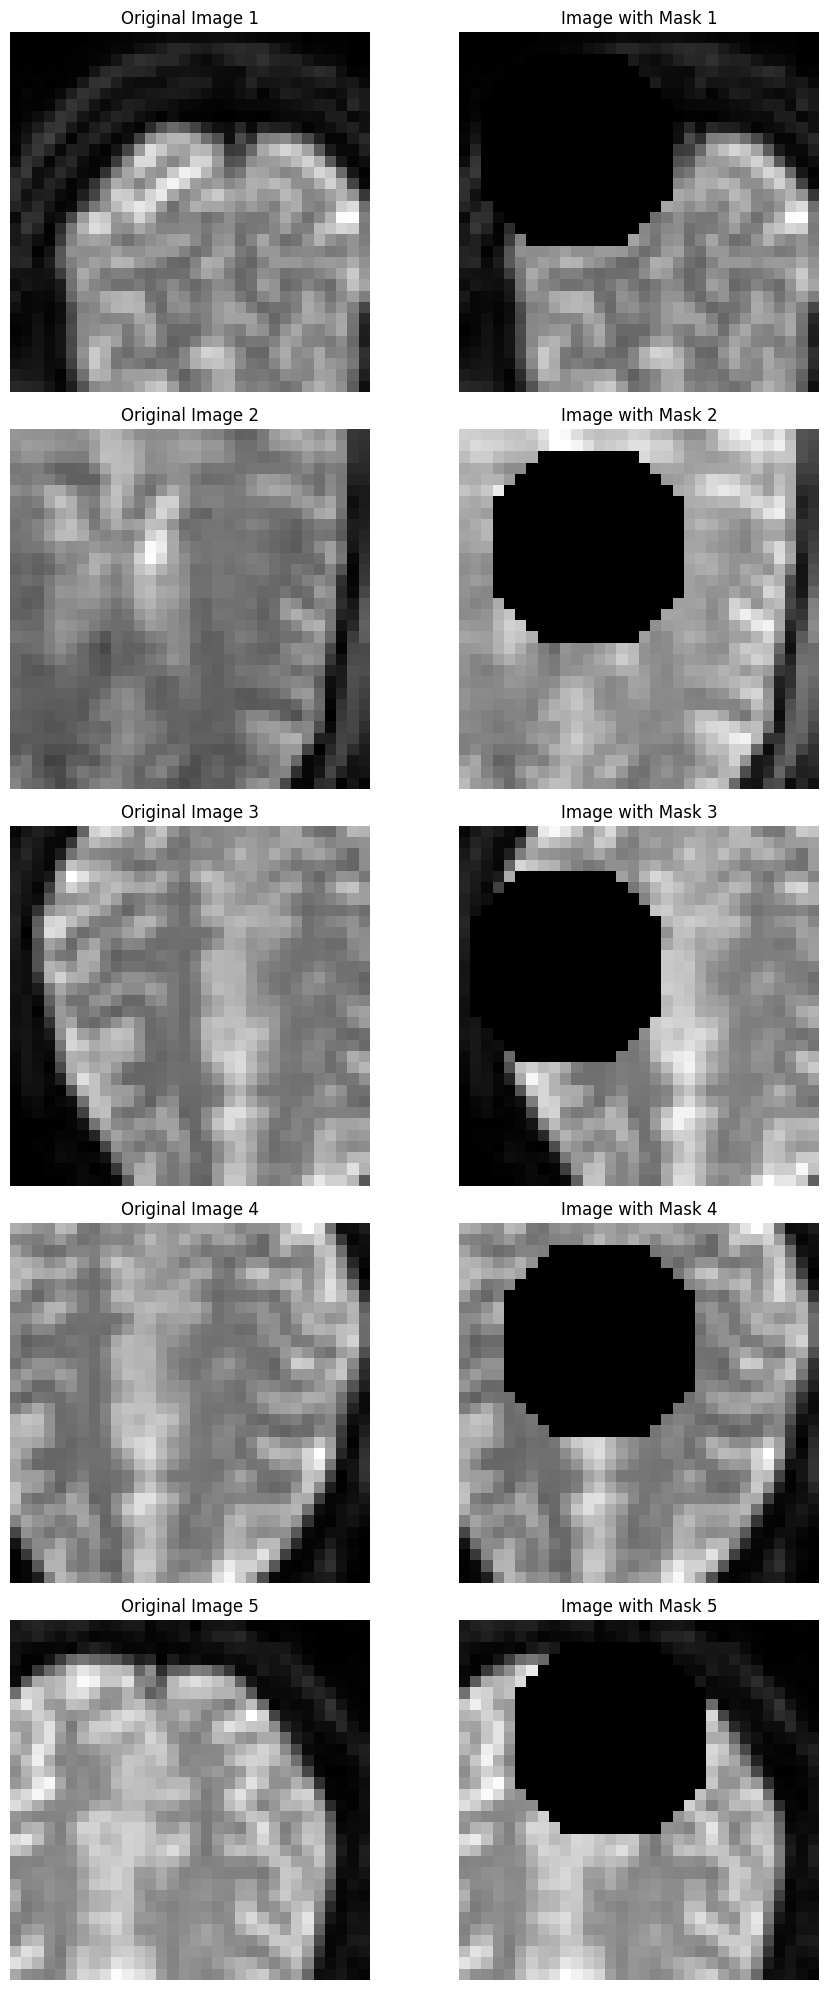

In [15]:
import matplotlib.pyplot as plt
import random

indices = random.sample(range(cropped_data.shape[0]), 5)

plt.figure(figsize=(10, 20))

for i, index in enumerate(indices):
    # original image
    plt.subplot(5, 2, i*2+1)
    plt.imshow(labels[index].T, cmap='gray')
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    # masked image
    plt.subplot(5, 2, i*2+2)
    plt.imshow(new_dataset[index].T, cmap='gray')
    plt.title(f'Image with Mask {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

#Method 1

##U-Net


Here we build a U-Net

In [16]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization,Activation

def create_model():
    inputs = Input((32, 32, 1))

    # encoder
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # middle
    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    # decoder
    up1 = UpSampling2D(size=(2, 2))(conv5)
    up1 = concatenate([conv4, up1], axis=-1)
    conv6 = Conv2D(512, (3, 3), padding='same')(up1)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    up2 = UpSampling2D(size=(2, 2))(conv6)
    up2 = concatenate([conv3, up2], axis=-1)
    conv7 = Conv2D(256, (3, 3), padding='same')(up2)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    up3 = UpSampling2D(size=(2, 2))(conv7)
    up3 = concatenate([conv2, up3], axis=-1)
    conv8 = Conv2D(128, (3, 3), padding='same')(up3)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    up4 = UpSampling2D(size=(2, 2))(conv8)
    up4 = concatenate([conv1, up4], axis=-1)
    conv9 = Conv2D(64, (3, 3), padding='same')(up4)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    # output layer
    conv10 = Conv2D(1, (1, 1), activation='sigmoid',padding='same')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

model = create_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   640         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['batch_normalization[0][0]']

##1. Using MSE as loss function

Split the data

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split

new_dataset1 = np.expand_dims(new_dataset, axis=-1)
labels1 = np.expand_dims(labels, axis=-1)

X_train, X_test, y_train, y_test = train_test_split(new_dataset1, labels1, test_size=0.2, random_state=42)


In [18]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model1 = create_model()
optimizer = Adam(learning_rate=0.001)
model1.compile(optimizer=optimizer, loss='mse')


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model1.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stop])


model1.evaluate(X_test, y_test)


Epoch 1/50
214/214 [==============================] - 27s 67ms/step - loss: 0.0062 - val_loss: 0.0771
Epoch 2/50
214/214 [==============================] - 11s 53ms/step - loss: 0.0033 - val_loss: 0.0686
Epoch 3/50
214/214 [==============================] - 11s 53ms/step - loss: 0.0029 - val_loss: 0.0147
Epoch 4/50
214/214 [==============================] - 11s 54ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 5/50
214/214 [==============================] - 11s 53ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 6/50
214/214 [==============================] - 11s 53ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 7/50
214/214 [==============================] - 11s 53ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 8/50
214/214 [==============================] - 11s 53ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 9/50
214/214 [==============================] - 11s 53ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 10/50
214/214 [==============================] - 11s 53ms/step - loss: 0.001

0.0007279947749339044

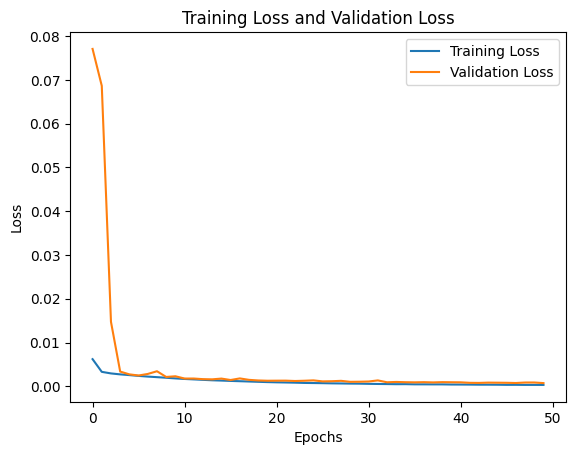

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0,0.01])
plt.legend()
plt.show()


Examples

1/1 [==============================] - 1s 685ms/step


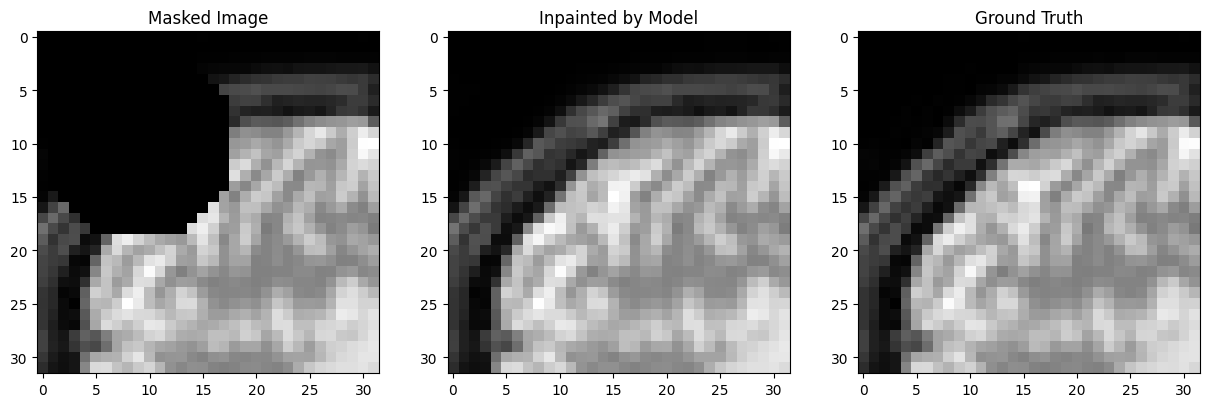

1/1 [==============================] - 0s 22ms/step


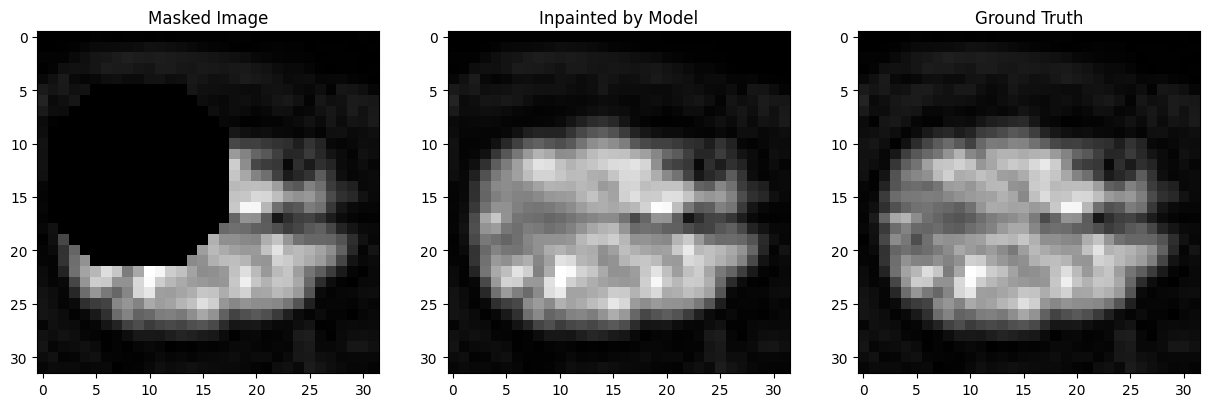

1/1 [==============================] - 0s 20ms/step


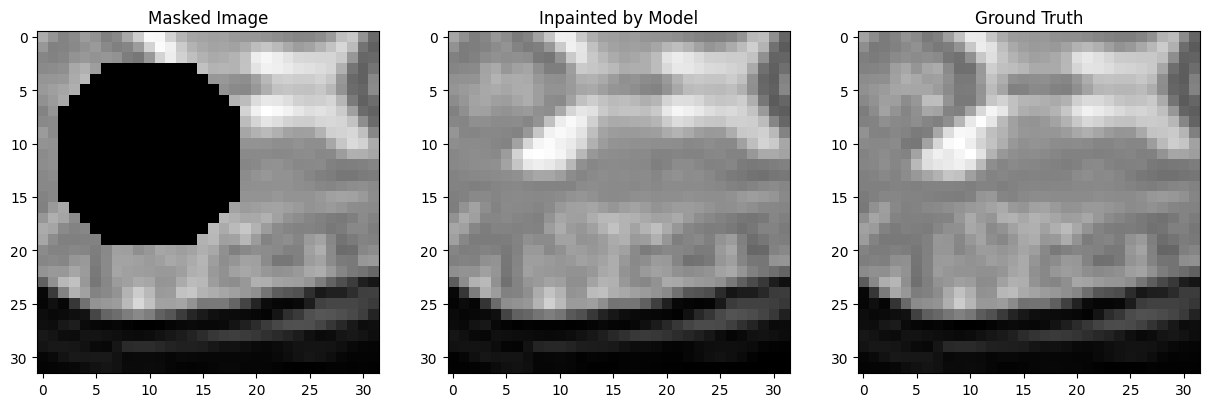

1/1 [==============================] - 0s 20ms/step


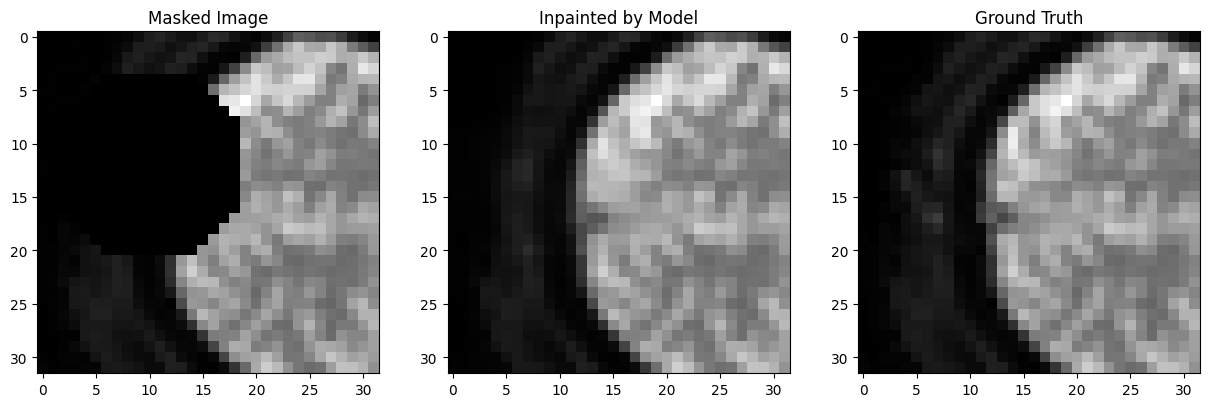

1/1 [==============================] - 0s 20ms/step


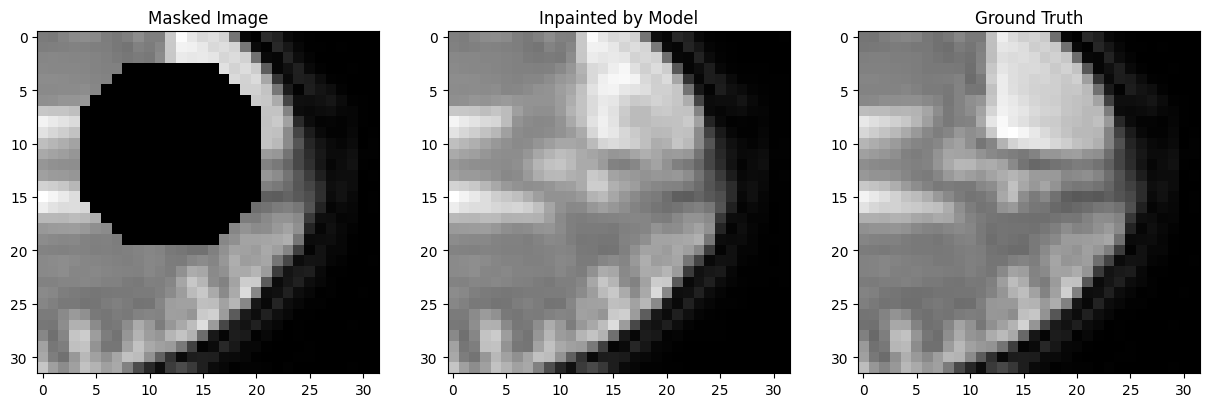

1/1 [==============================] - 0s 19ms/step


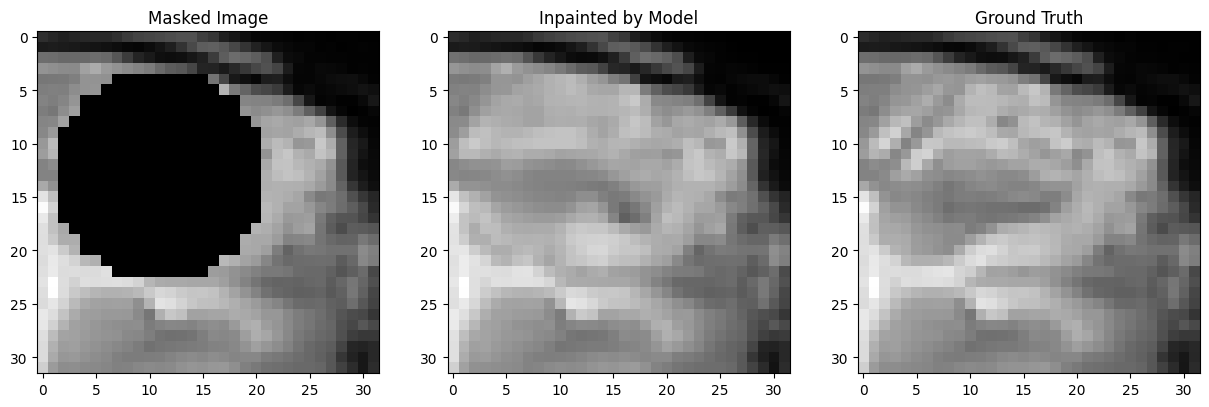

1/1 [==============================] - 0s 20ms/step


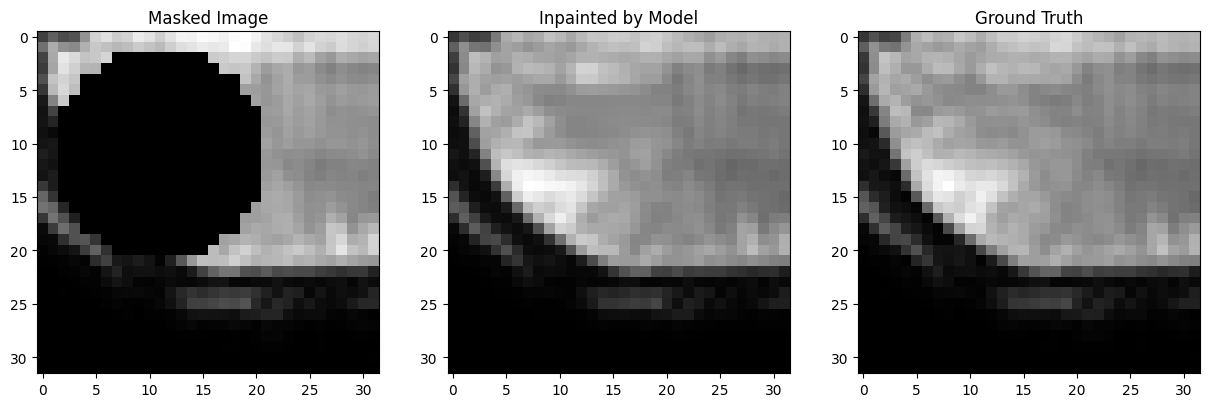

1/1 [==============================] - 0s 21ms/step


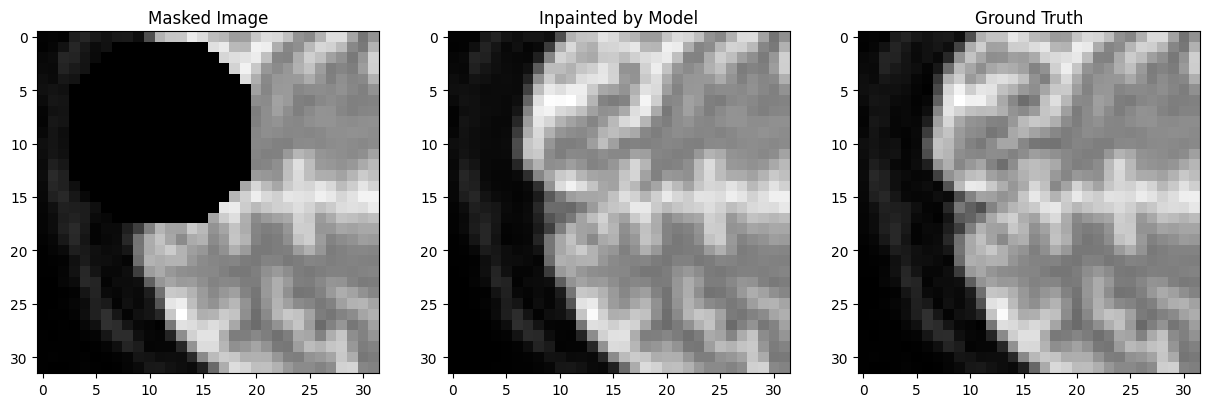

1/1 [==============================] - 0s 21ms/step


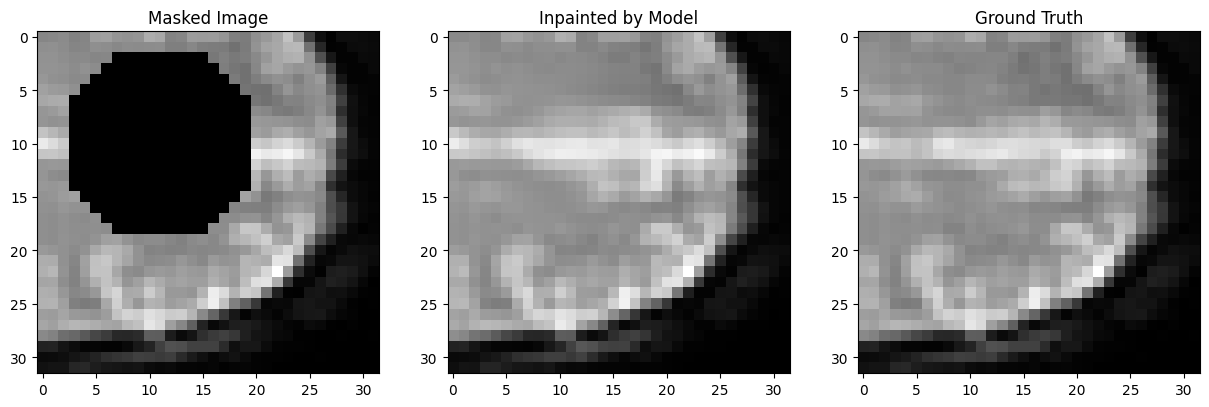

1/1 [==============================] - 0s 19ms/step


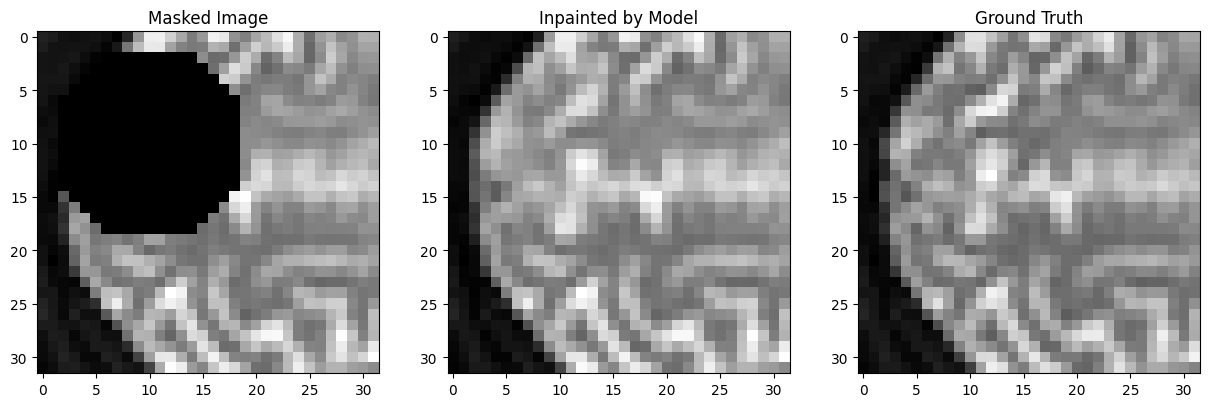

In [20]:
import matplotlib.pyplot as plt

np.random.seed(0)
num_images_to_show = 10

for i in range(num_images_to_show):
    img_index = np.random.randint(X_test.shape[0])

    original = X_test[img_index]
    ground_truth = y_test[img_index]
    prediction = model1.predict(original[np.newaxis, ...])[0]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original.squeeze(), cmap='gray')
    plt.title('Masked Image')

    plt.subplot(1, 3, 2)
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.title('Inpainted by Model')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth.squeeze(), cmap='gray')
    plt.title('Ground Truth')

    plt.show()


##2. Using SSIM as loss function

In [21]:
# import numpy as np
# from sklearn.model_selection import train_test_split

# new_dataset = np.expand_dims(new_dataset, axis=-1)
# labels = np.expand_dims(labels, axis=-1)

# X_train, X_test, y_train, y_test = train_test_split(new_dataset, labels, test_size=0.2, random_state=42)
# import numpy as np



# print(X_test.shape)
# print(y_test.shape)

In [22]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf

# Define SSIM Loss
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))  #set 1.0 here because the range of images is [0,1]

model2 = create_model()
optimizer = Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss=ssim_loss)


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model2.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stop])




Epoch 1/50
214/214 [==============================] - 15s 59ms/step - loss: 0.2613 - val_loss: 0.7719
Epoch 2/50
214/214 [==============================] - 12s 56ms/step - loss: 0.2072 - val_loss: 0.6341
Epoch 3/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1850 - val_loss: 0.4119
Epoch 4/50
214/214 [==============================] - 12s 55ms/step - loss: 0.1645 - val_loss: 0.1748
Epoch 5/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1490 - val_loss: 0.1585
Epoch 6/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1350 - val_loss: 0.1383
Epoch 7/50
214/214 [==============================] - 12s 55ms/step - loss: 0.1209 - val_loss: 0.1286
Epoch 8/50
214/214 [==============================] - 12s 55ms/step - loss: 0.1067 - val_loss: 0.1184
Epoch 9/50
214/214 [==============================] - 12s 55ms/step - loss: 0.0937 - val_loss: 0.1085
Epoch 10/50
214/214 [==============================] - 12s 55ms/step - loss: 0.083

In [23]:
model2.evaluate(X_test, y_test)

268/268 [==============================] - 2s 8ms/step - loss: 0.0420


0.04204583540558815

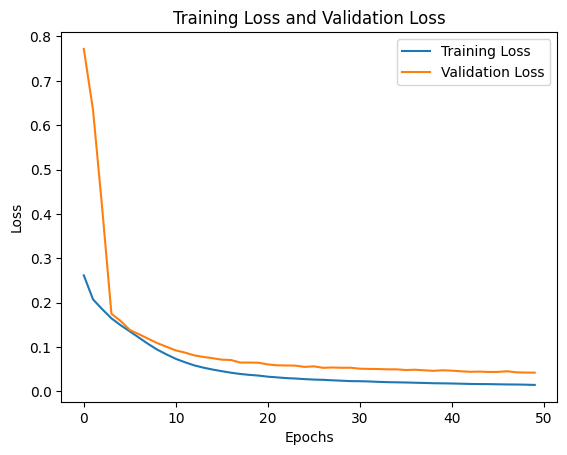

In [24]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

1/1 [==============================] - 0s 329ms/step


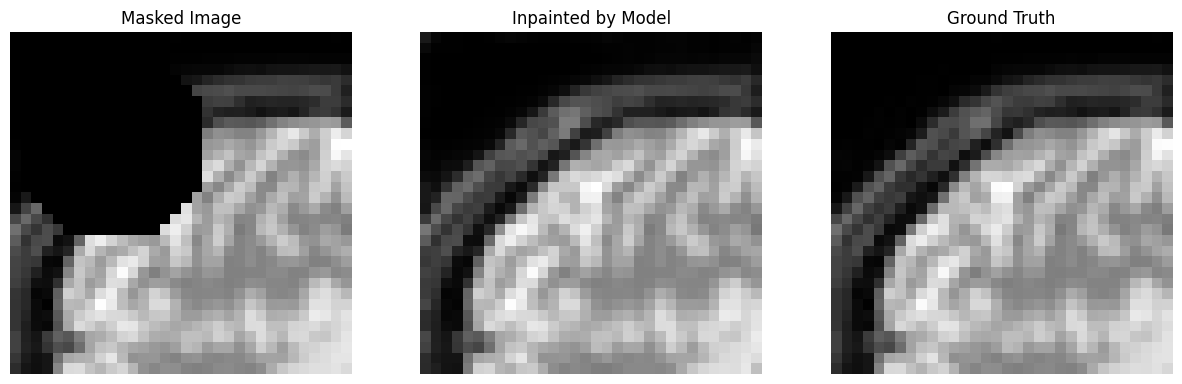

1/1 [==============================] - 0s 20ms/step


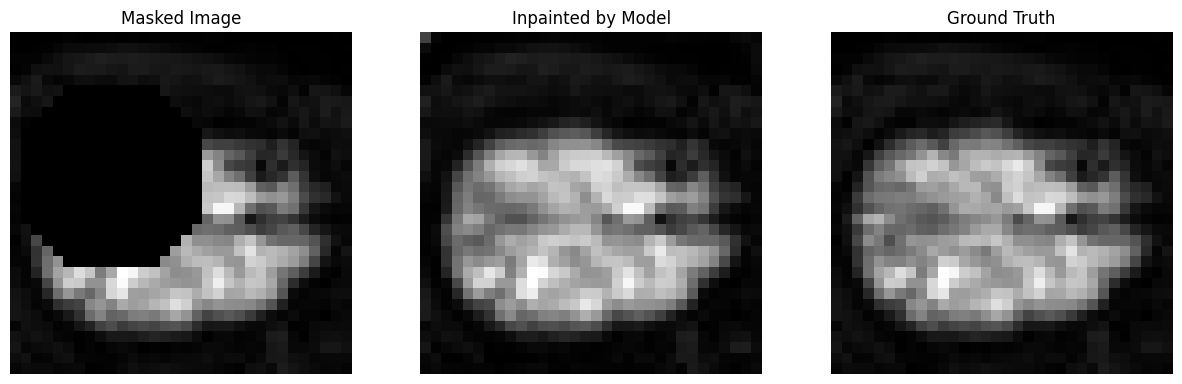

1/1 [==============================] - 0s 18ms/step


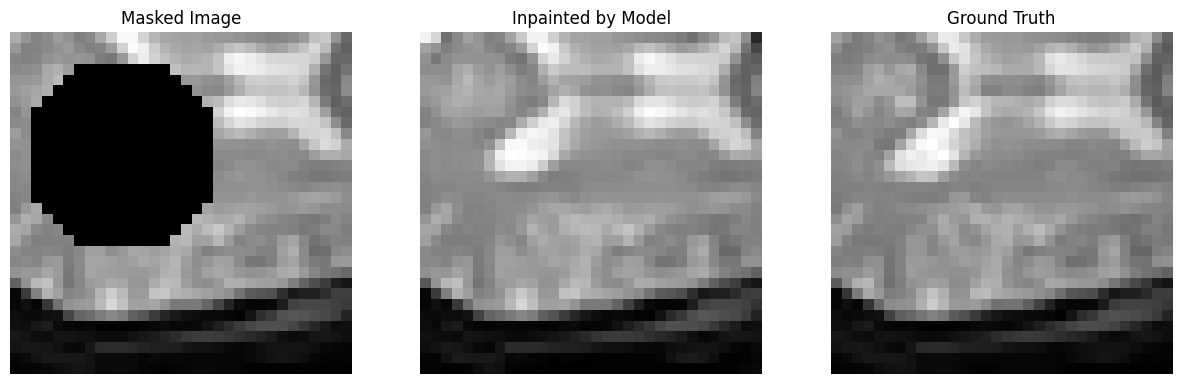

1/1 [==============================] - 0s 19ms/step


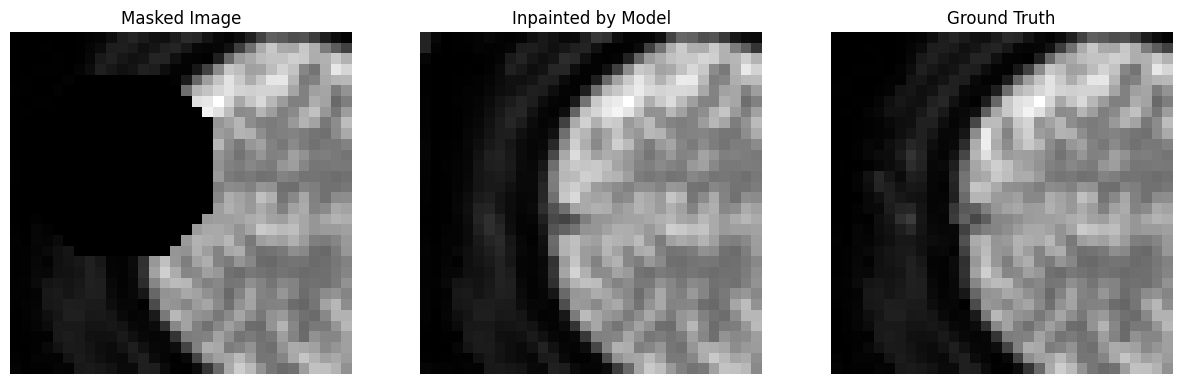

1/1 [==============================] - 0s 19ms/step


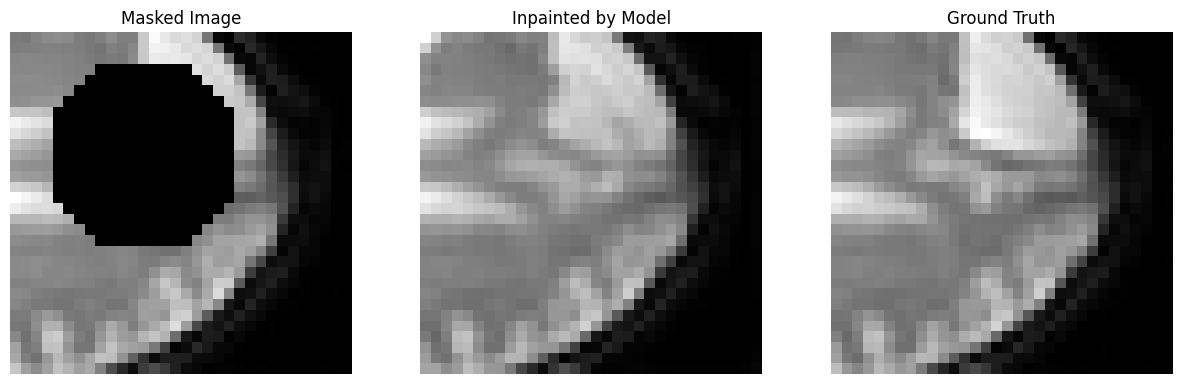

1/1 [==============================] - 0s 20ms/step


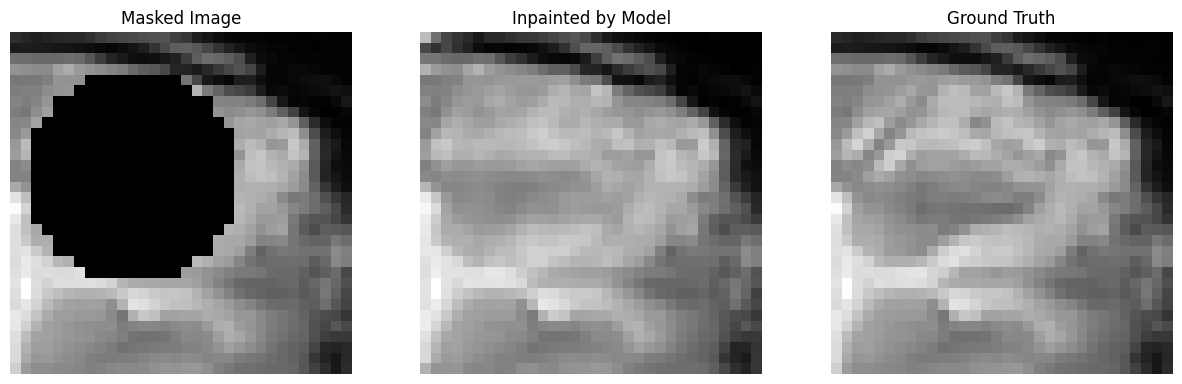

1/1 [==============================] - 0s 20ms/step


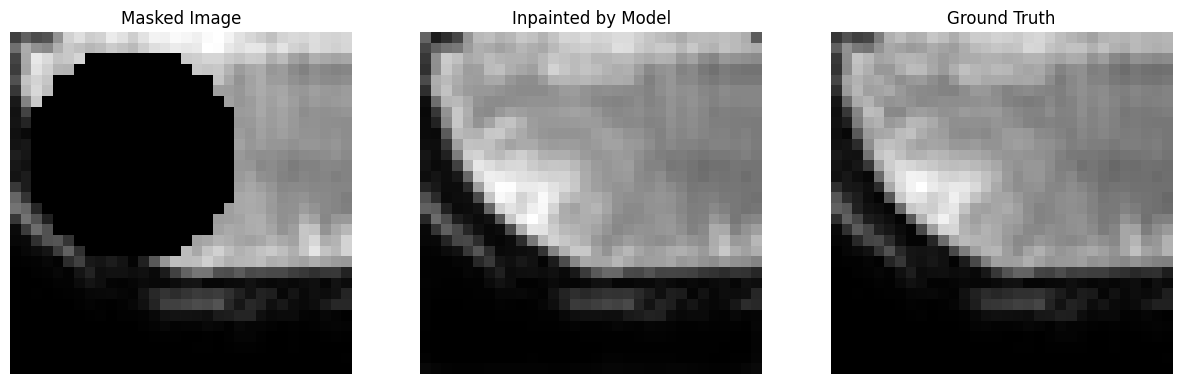

1/1 [==============================] - 0s 20ms/step


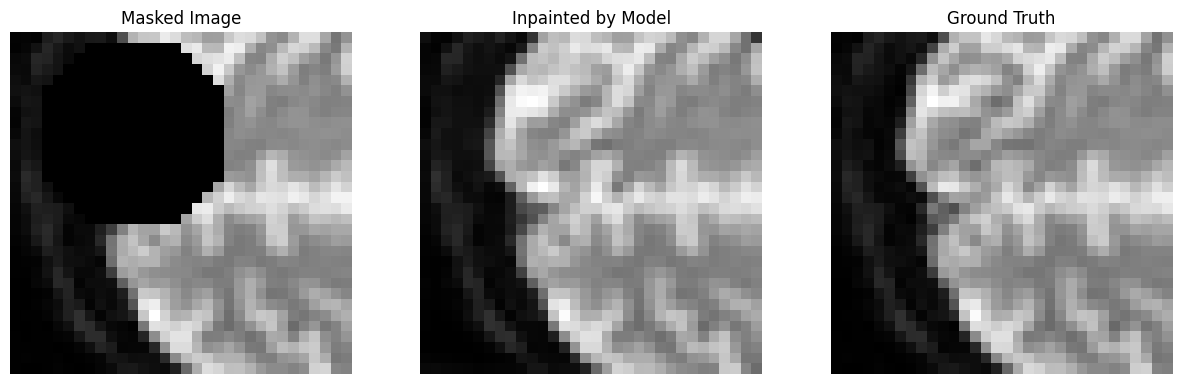

1/1 [==============================] - 0s 20ms/step


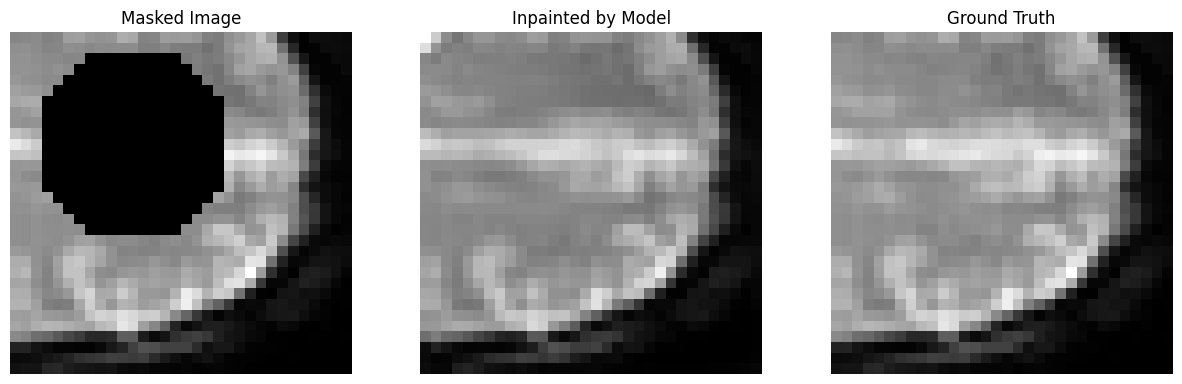

1/1 [==============================] - 0s 19ms/step


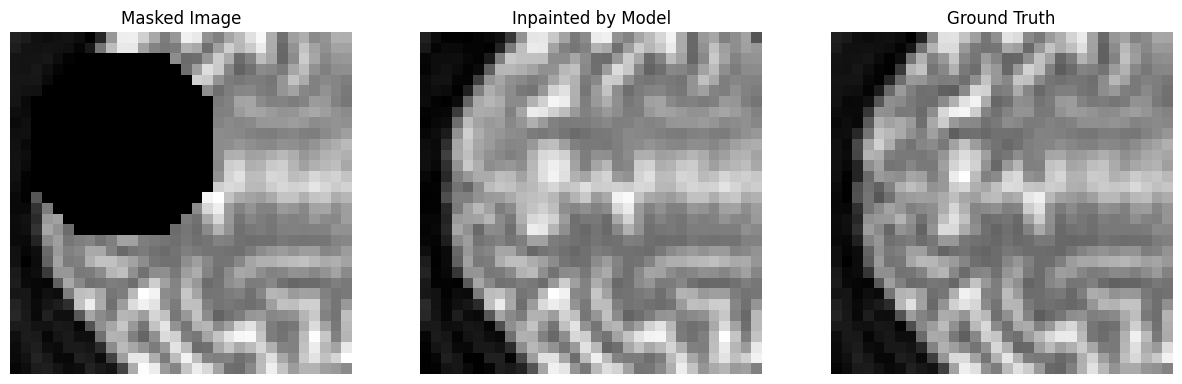

In [25]:
import matplotlib.pyplot as plt

np.random.seed(0)
num_images_to_show = 10

for i in range(num_images_to_show):

    img_index = np.random.randint(X_test.shape[0])

    original = X_test[img_index]
    ground_truth = y_test[img_index]
    prediction = model2.predict(original[np.newaxis, ...])[0]


    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original.squeeze(), cmap='gray')
    plt.title('Masked Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.title('Inpainted by Model')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth.squeeze(), cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.show()

##3. Combined loss functions

In [26]:
import tensorflow as tf
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


def ssim_bce(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0)) + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred, labels=y_true))

def ssim_mse(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0)) + 10*tf.reduce_mean(tf.square(y_true - y_pred))  #set 1.0 here because the range of images is [0,1]

model3 = create_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer=optimizer, loss=ssim_mse)


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model3.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stop])

Epoch 1/50
214/214 [==============================] - 26s 59ms/step - loss: 0.3447 - val_loss: 1.4669
Epoch 2/50
214/214 [==============================] - 12s 56ms/step - loss: 0.2464 - val_loss: 1.2416
Epoch 3/50
214/214 [==============================] - 12s 56ms/step - loss: 0.2247 - val_loss: 0.7009
Epoch 4/50
214/214 [==============================] - 12s 55ms/step - loss: 0.2041 - val_loss: 0.2335
Epoch 5/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1827 - val_loss: 0.1832
Epoch 6/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1661 - val_loss: 0.1729
Epoch 7/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1511 - val_loss: 0.1666
Epoch 8/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1367 - val_loss: 0.1469
Epoch 9/50
214/214 [==============================] - 12s 55ms/step - loss: 0.1237 - val_loss: 0.1489
Epoch 10/50
214/214 [==============================] - 12s 56ms/step - loss: 0.108

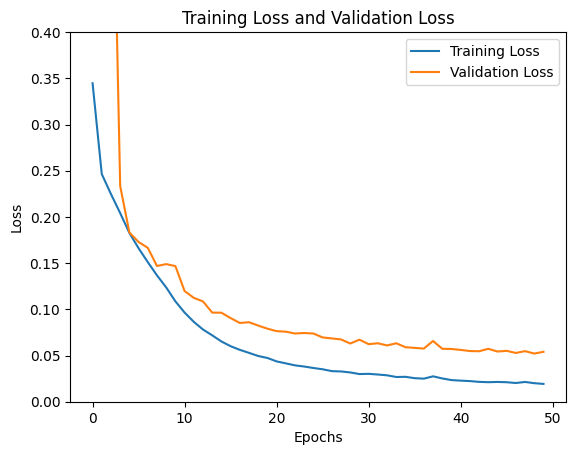

In [27]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0,0.4])
plt.legend()
plt.show()

1/1 [==============================] - 0s 322ms/step


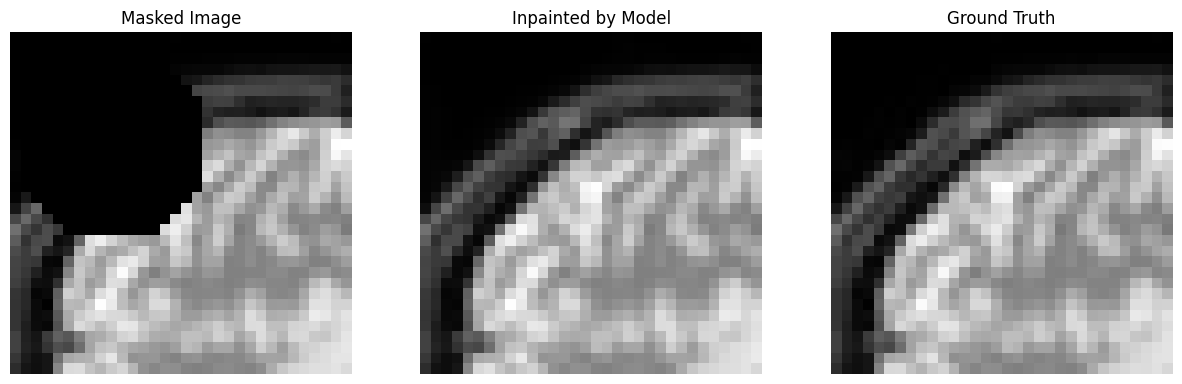

1/1 [==============================] - 0s 19ms/step


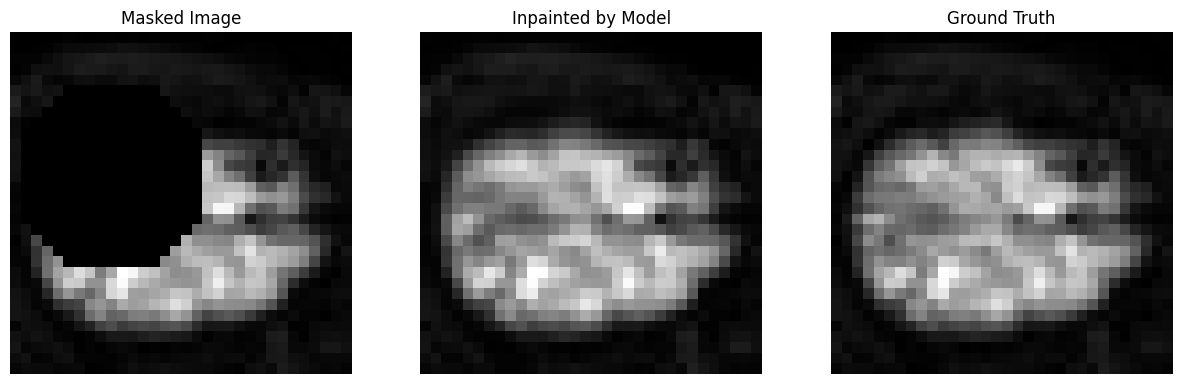

1/1 [==============================] - 0s 23ms/step


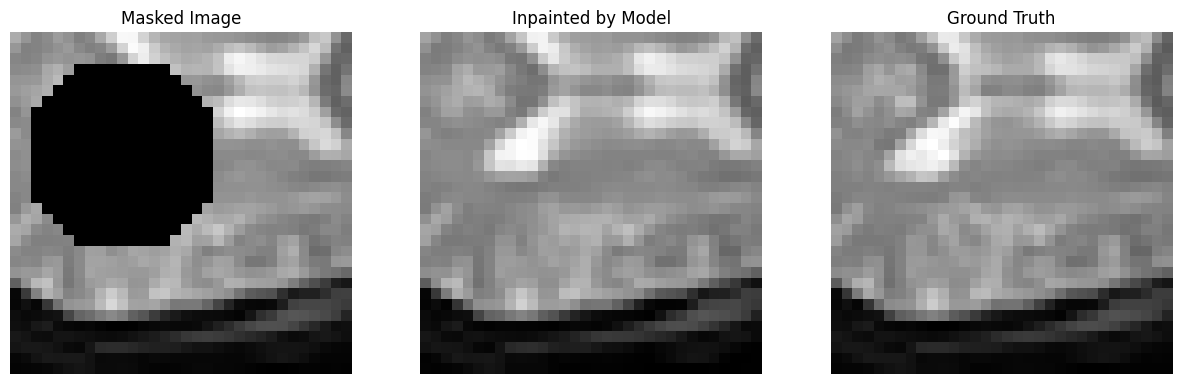

1/1 [==============================] - 0s 21ms/step


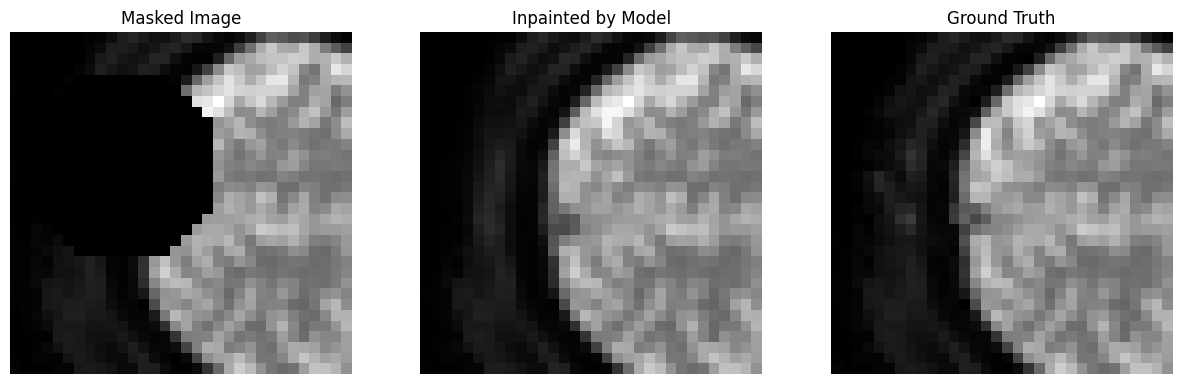

1/1 [==============================] - 0s 20ms/step


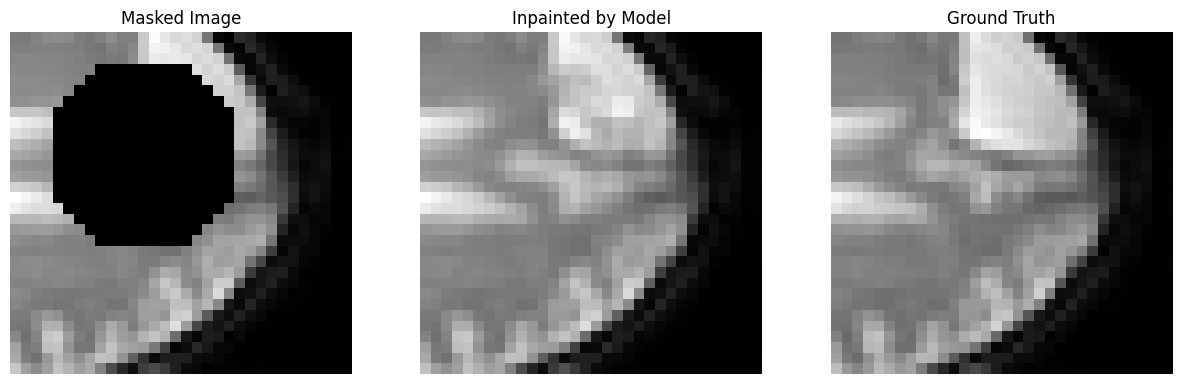

1/1 [==============================] - 0s 21ms/step


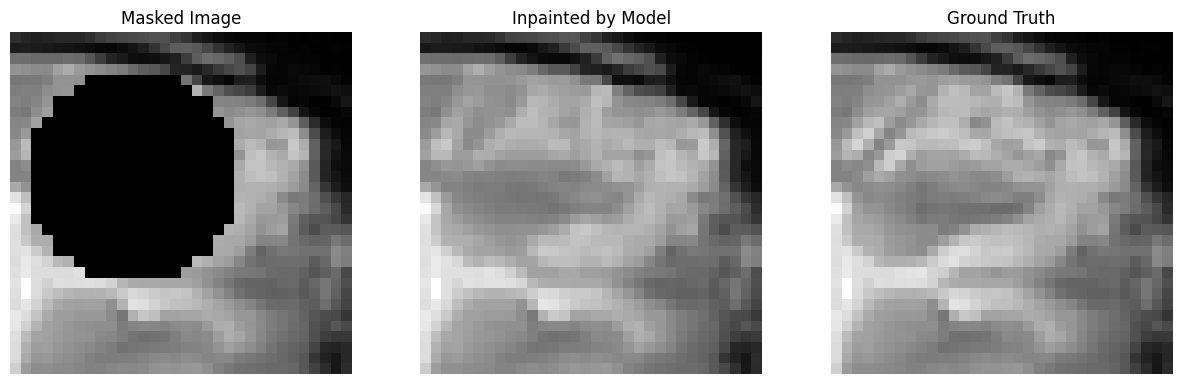

1/1 [==============================] - 0s 20ms/step


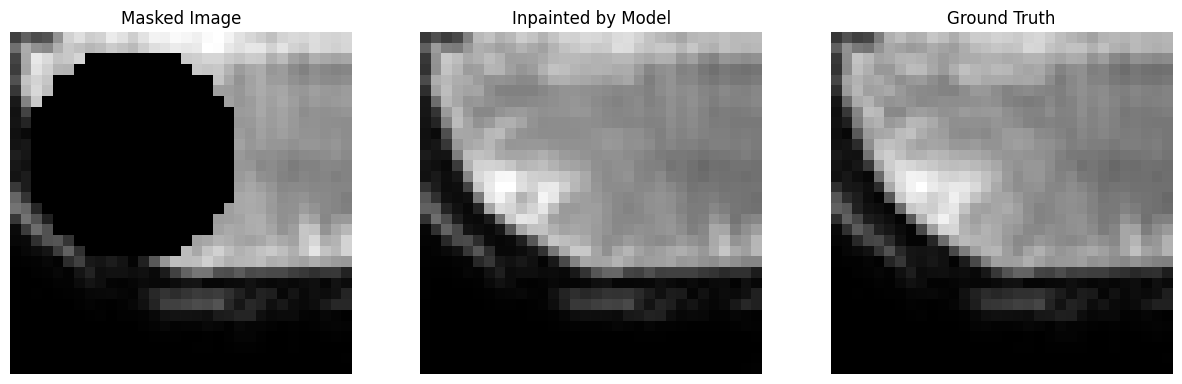

1/1 [==============================] - 0s 20ms/step


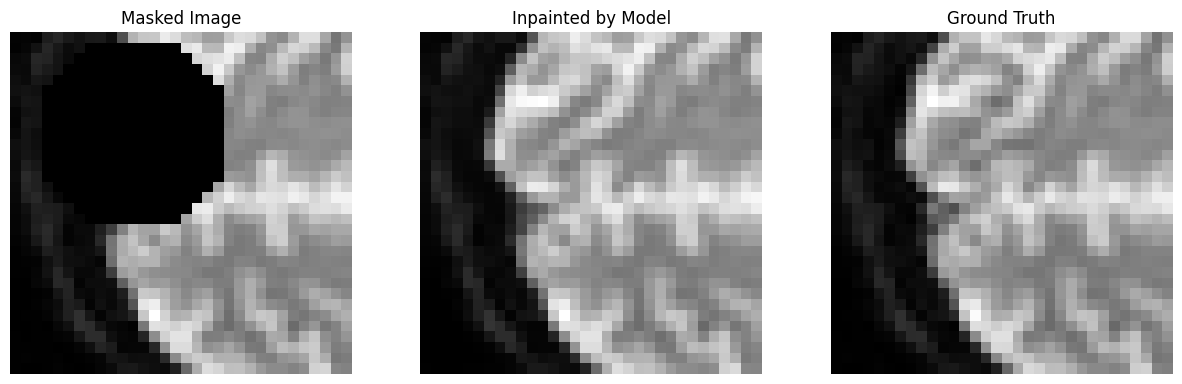

1/1 [==============================] - 0s 19ms/step


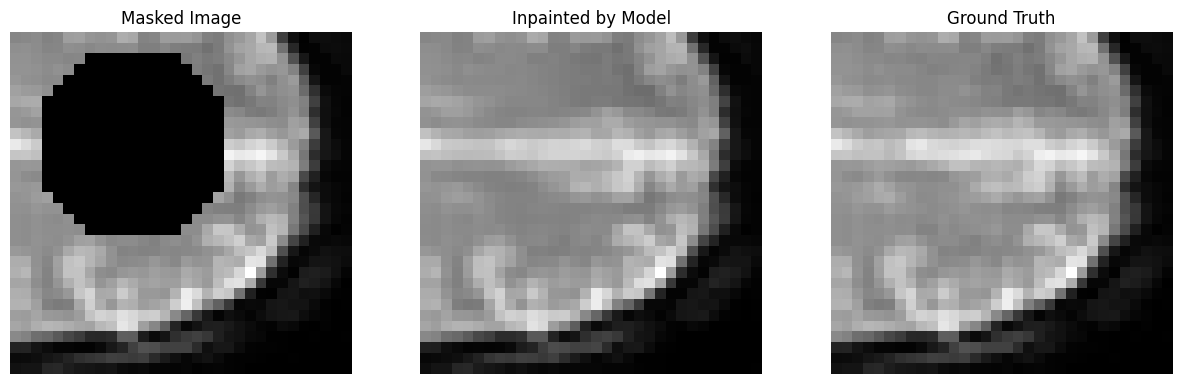

1/1 [==============================] - 0s 19ms/step


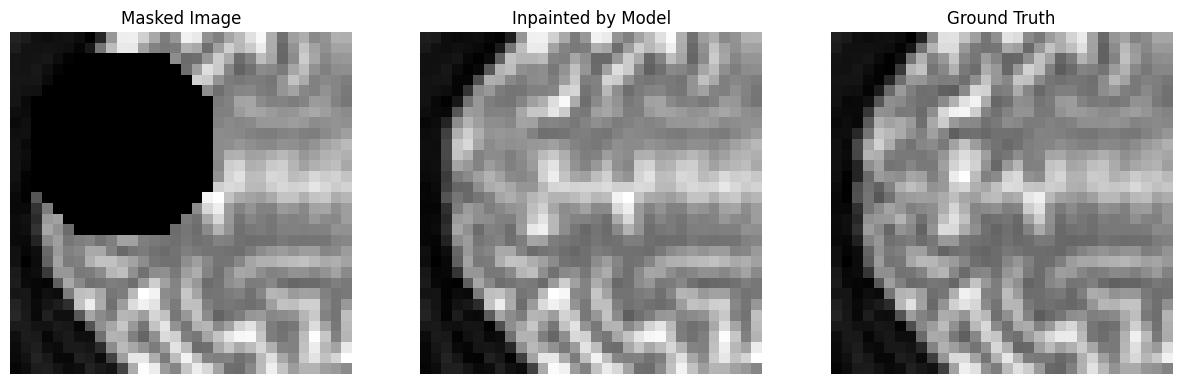

In [28]:
import matplotlib.pyplot as plt

np.random.seed(0)
num_images_to_show = 10

for i in range(num_images_to_show):

    img_index = np.random.randint(X_test.shape[0])

    original = X_test[img_index]
    ground_truth = y_test[img_index]
    prediction = model3.predict(original[np.newaxis, ...])[0]


    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original.squeeze(), cmap='gray')
    plt.title('Masked Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.title('Inpainted by Model')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth.squeeze(), cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.show()

##Playground

In [29]:
# import tensorflow as tf

# # def masked_ssim(y_true, y_pred):
# #     mask = y_true > 0  # Assuming mask area has positive values and the rest are zeros
# #     y_true_masked = tf.boolean_mask(y_true, mask)
# #     y_pred_masked = tf.boolean_mask(y_pred, mask)
# #     return 1 - tf.reduce_mean(tf.image.ssim(y_true_masked, y_pred_masked, 1.0))  #set 1.0 here because the range of images is [0,1]

# # Define SSIM Loss
# def ssim_loss(y_true, y_pred):
#     return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))  #set 1.0 here because the range of images is [0,1]

# def masked_ssim(y_true, y_pred):
#     mask = y_true == 0
#     y_true_masked = tf.boolean_mask(y_true, mask)
#     y_pred_masked = tf.boolean_mask(y_pred, mask)
#     y_true_masked = tf.reshape(y_true_masked, (-1, 32, 32, 1))
#     y_pred_masked = tf.reshape(y_pred_masked, (-1, 32, 32, 1))
#     return 1 - tf.reduce_mean(tf.image.ssim(y_true_masked, y_pred_masked, 1.0))  #set 1.0 here because the range of images is [0,1]






# model4 = create_model()
# optimizer = Adam(learning_rate=0.001)
# model4.compile(optimizer=optimizer, loss='mse')


# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# history = model4.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stop])


# model4.evaluate(X_test, y_test)


# Method 2


##U-Net

In [30]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization,Activation

from tensorflow.keras.layers import Layer

class RestorationLayer(Layer):
    def __init__(self, **kwargs):
        super(RestorationLayer, self).__init__(**kwargs)

    def call(self, inputs):
        model_output, original_image, mask = inputs

        output_unmasked = model_output * (1 - mask)
        output_masked = original_image * mask
        final_output = output_unmasked + output_masked

        return final_output



def create_model():
    inputs = Input((32, 32, 1))
    original_image = Input((32, 32, 1))
    mask = Input((32, 32, 1))


    # encoder
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # middle
    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    # decoder
    up1 = UpSampling2D(size=(2, 2))(conv5)
    up1 = concatenate([conv4, up1], axis=-1)
    conv6 = Conv2D(512, (3, 3), padding='same')(up1)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    up2 = UpSampling2D(size=(2, 2))(conv6)
    up2 = concatenate([conv3, up2], axis=-1)
    conv7 = Conv2D(256, (3, 3), padding='same')(up2)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    up3 = UpSampling2D(size=(2, 2))(conv7)
    up3 = concatenate([conv2, up3], axis=-1)
    conv8 = Conv2D(128, (3, 3), padding='same')(up3)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    up4 = UpSampling2D(size=(2, 2))(conv8)
    up4 = concatenate([conv1, up4], axis=-1)
    conv9 = Conv2D(64, (3, 3), padding='same')(up4)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    # output layer
    conv10 = Conv2D(1, (1, 1), activation='sigmoid',padding='same')(conv9)
    restored_image = RestorationLayer()([conv10, original_image, mask])

    model = Model(inputs=[inputs, original_image, mask], outputs=[restored_image])

    return model

model = create_model()
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_76 (Conv2D)             (None, 32, 32, 64)   640         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_72 (BatchN  (None, 32, 32, 64)  256         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_72 (Activation)     (None, 32, 32, 64)   0           ['batch_normalization_72[0]

In [31]:
import numpy as np
from sklearn.model_selection import train_test_split

new_dataset1 = np.expand_dims(new_dataset, axis=-1)
labels1 = np.expand_dims(labels, axis=-1)
masks1 = np.expand_dims(masks, axis=-1)

X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(new_dataset1, labels1, masks1, test_size=0.2, random_state=42)

##Using mse as lose function

In [32]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf



model5 = create_model()
optimizer = Adam(learning_rate=0.001)
model5.compile(optimizer=optimizer, loss=ssim_loss)



early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model5.fit([X_train, y_train, masks_train], y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stop])


model5.evaluate([X_test, y_test, masks_test], y_test)


Epoch 1/50
214/214 [==============================] - 15s 60ms/step - loss: 0.2411 - val_loss: 0.5428
Epoch 2/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1974 - val_loss: 0.4844
Epoch 3/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1718 - val_loss: 0.2873
Epoch 4/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1524 - val_loss: 0.1684
Epoch 5/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1374 - val_loss: 0.1410
Epoch 6/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1229 - val_loss: 0.1290
Epoch 7/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1093 - val_loss: 0.1223
Epoch 8/50
214/214 [==============================] - 12s 56ms/step - loss: 0.0955 - val_loss: 0.1106
Epoch 9/50
214/214 [==============================] - 12s 56ms/step - loss: 0.0833 - val_loss: 0.0995
Epoch 10/50
214/214 [==============================] - 12s 56ms/step - loss: 0.073

0.04166784882545471

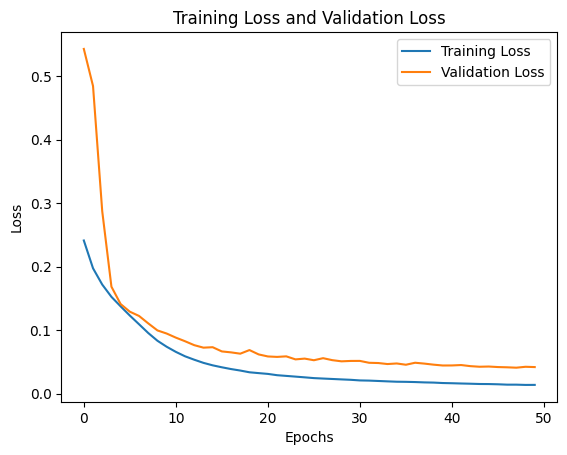

In [33]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0,0.01])
plt.legend()
plt.show()


1/1 [==============================] - 0s 338ms/step


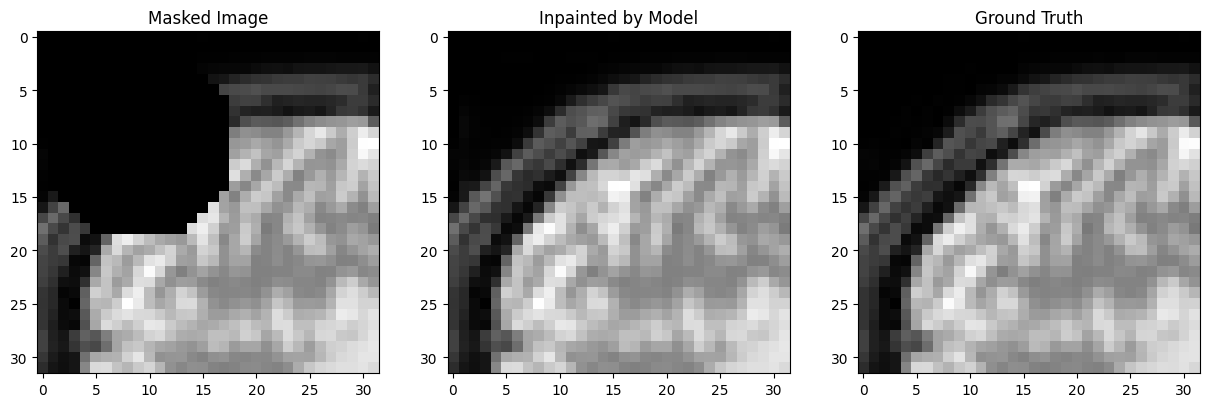

1/1 [==============================] - 0s 25ms/step


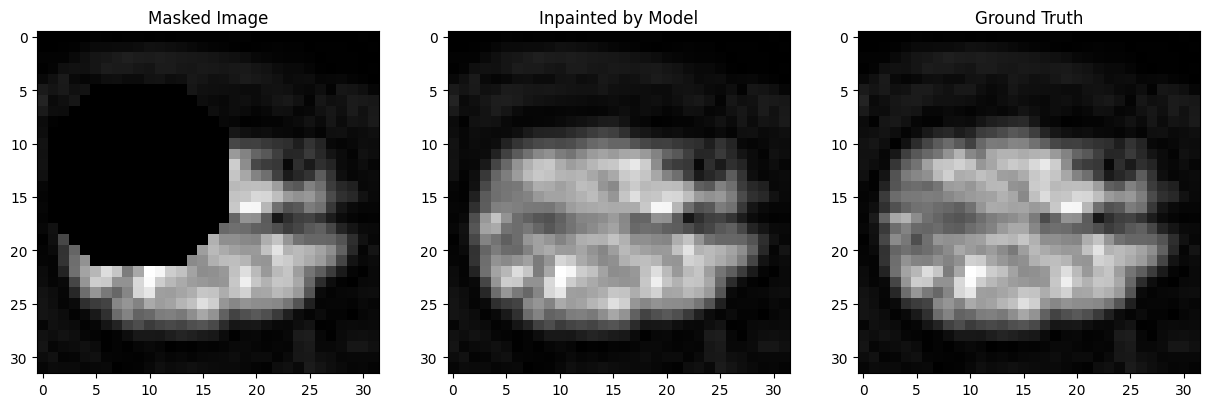

1/1 [==============================] - 0s 21ms/step


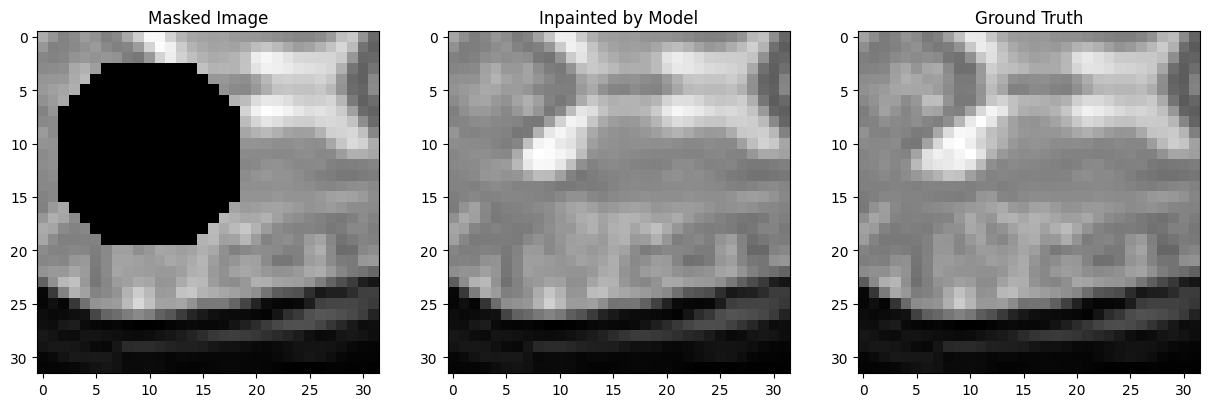

1/1 [==============================] - 0s 21ms/step


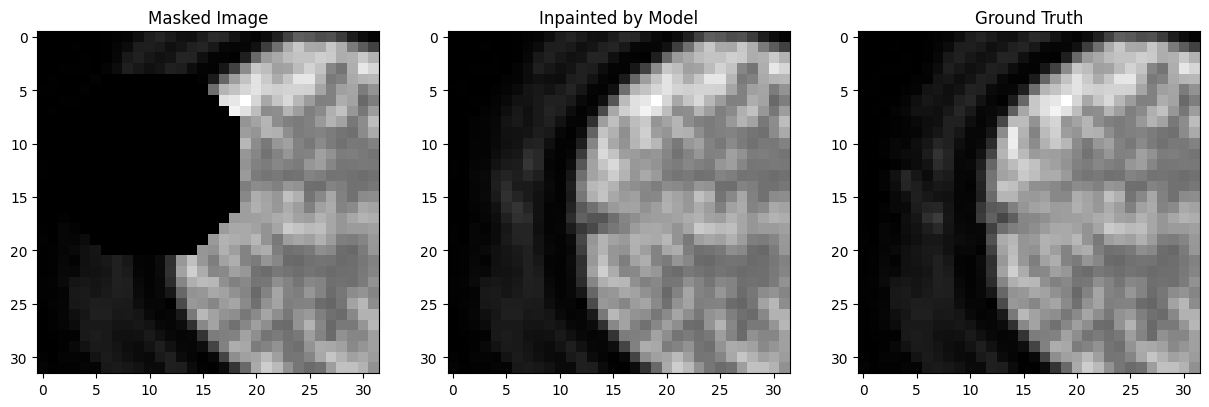

1/1 [==============================] - 0s 23ms/step


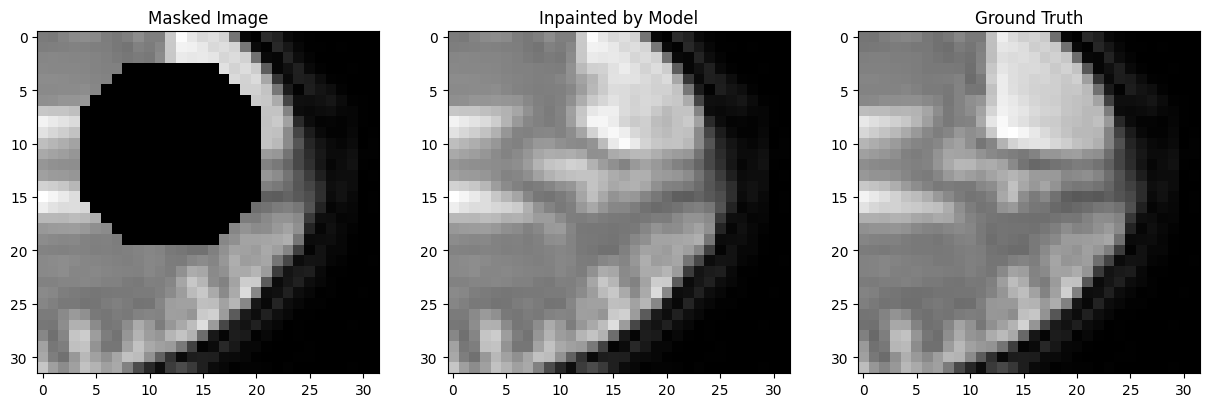

1/1 [==============================] - 0s 24ms/step


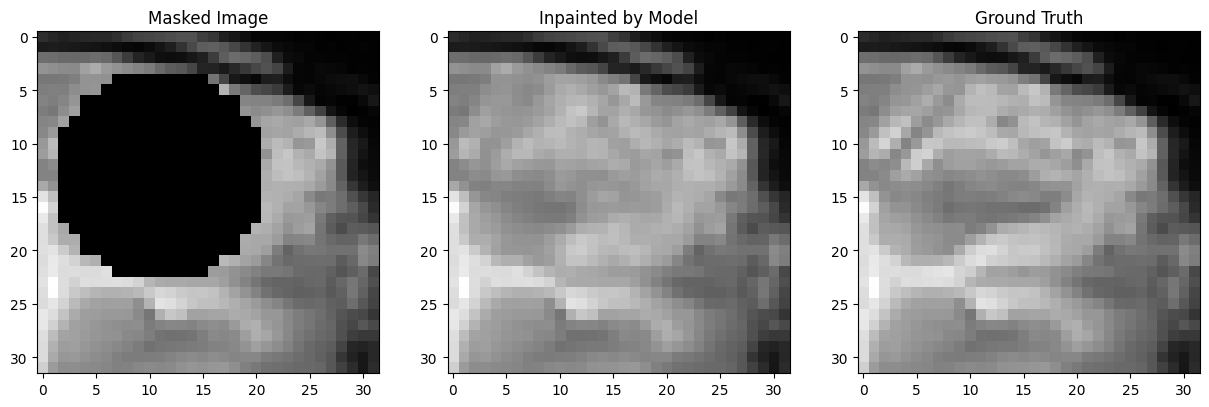

1/1 [==============================] - 0s 22ms/step


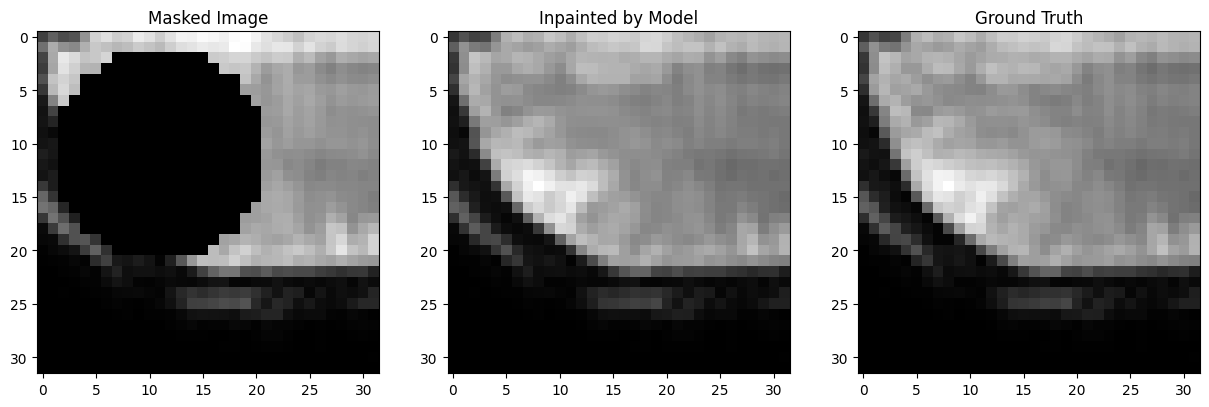

1/1 [==============================] - 0s 23ms/step


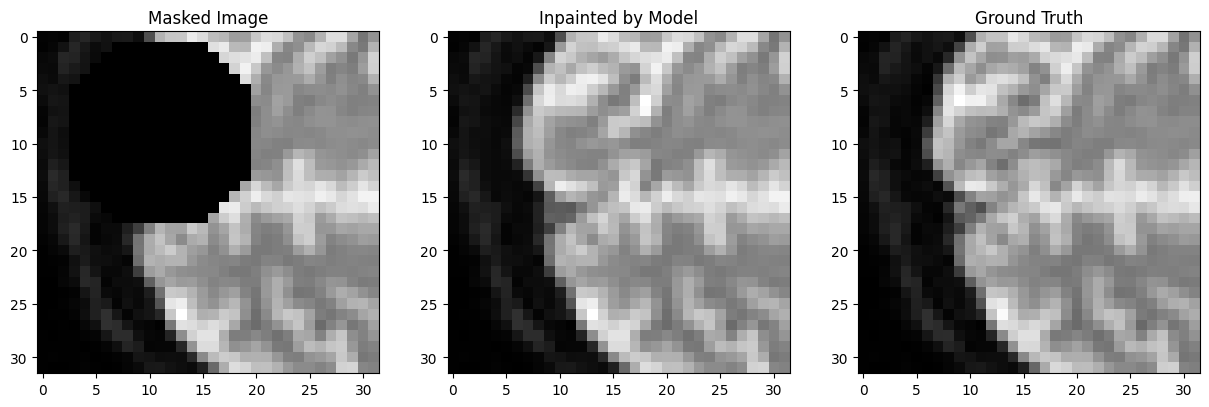

1/1 [==============================] - 0s 23ms/step


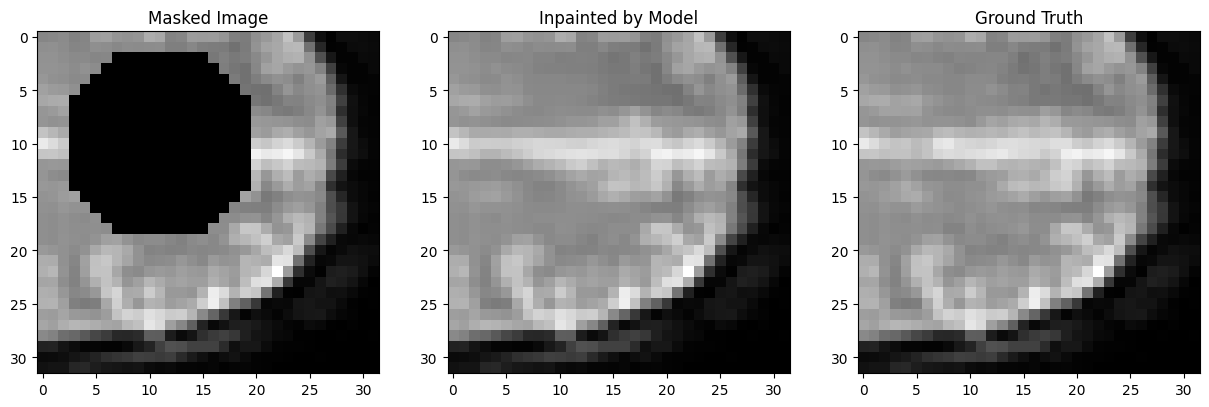

1/1 [==============================] - 0s 21ms/step


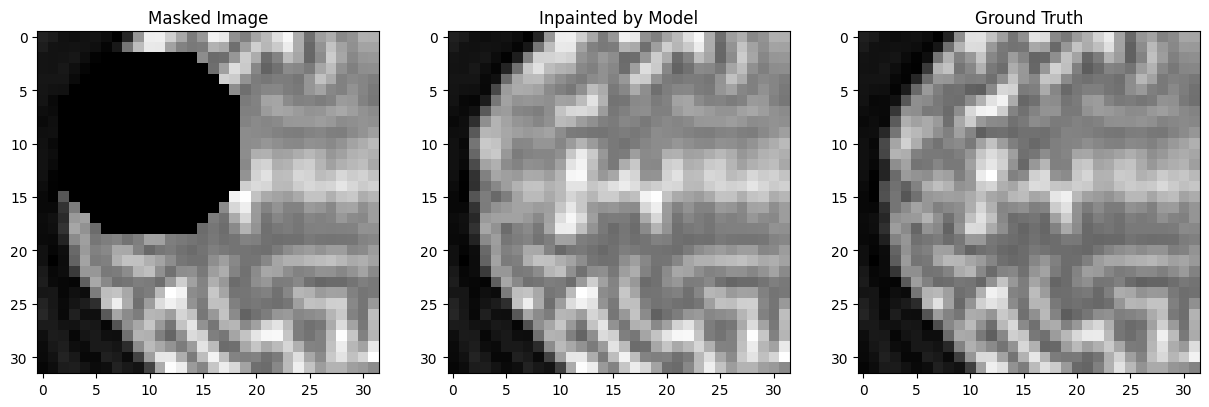

In [34]:
import matplotlib.pyplot as plt

np.random.seed(0)
num_images_to_show = 10

for i in range(num_images_to_show):
    img_index = np.random.randint(len(X_test))  # Use the length of your dataset

    masked_image = X_test[img_index]
    original_image = y_test[img_index]
    mask = masks_test[img_index]
    prediction = model5.predict([masked_image[np.newaxis, ...], original_image[np.newaxis, ...], mask[np.newaxis, ...]])[0]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(masked_image.squeeze(), cmap='gray')
    plt.title('Masked Image')

    plt.subplot(1, 3, 2)
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.title('Inpainted by Model')

    plt.subplot(1, 3, 3)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Ground Truth')

    plt.show()


##Using SSIM as loss function

In [35]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))  #set 1.0 here because the range of images is [0,1]

model6 = create_model()
optimizer = Adam(learning_rate=0.001)
model6.compile(optimizer=optimizer, loss=ssim_loss)


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model6.fit([X_train, y_train, masks_train], y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stop])


model6.evaluate([X_test, y_test,masks_test], y_test)


Epoch 1/50
214/214 [==============================] - 15s 59ms/step - loss: 0.2410 - val_loss: 0.5021
Epoch 2/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1986 - val_loss: 0.4903
Epoch 3/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1715 - val_loss: 0.3295
Epoch 4/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1532 - val_loss: 0.1641
Epoch 5/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1364 - val_loss: 0.1393
Epoch 6/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1222 - val_loss: 0.1286
Epoch 7/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1088 - val_loss: 0.1229
Epoch 8/50
214/214 [==============================] - 12s 56ms/step - loss: 0.0946 - val_loss: 0.1071
Epoch 9/50
214/214 [==============================] - 12s 56ms/step - loss: 0.0828 - val_loss: 0.0978
Epoch 10/50
214/214 [==============================] - 12s 56ms/step - loss: 0.073

0.04055513069033623

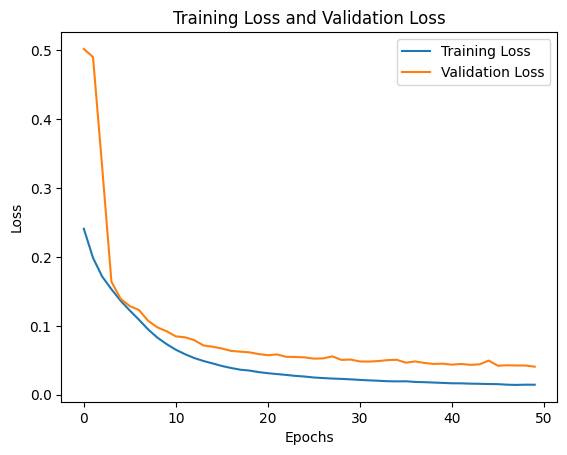

In [36]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0,0.01])
plt.legend()
plt.show()


1/1 [==============================] - 0s 336ms/step


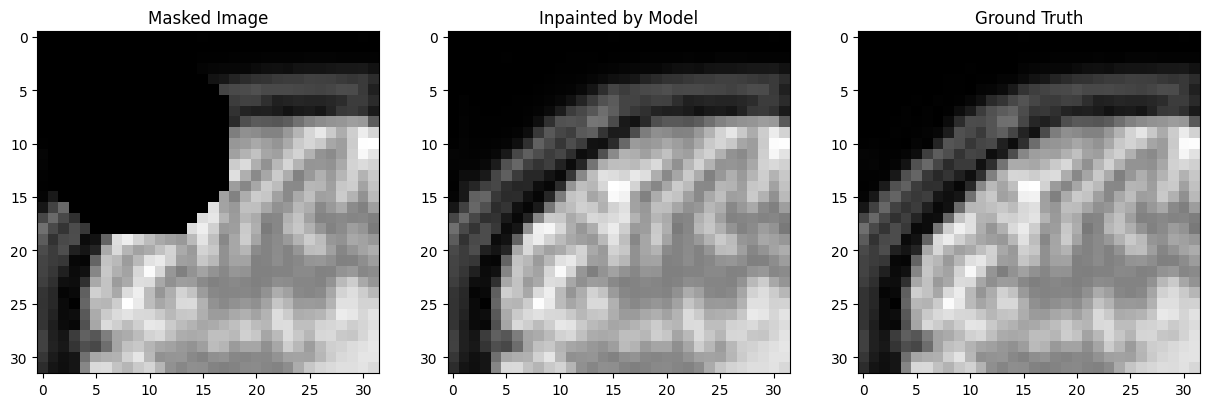

1/1 [==============================] - 0s 22ms/step


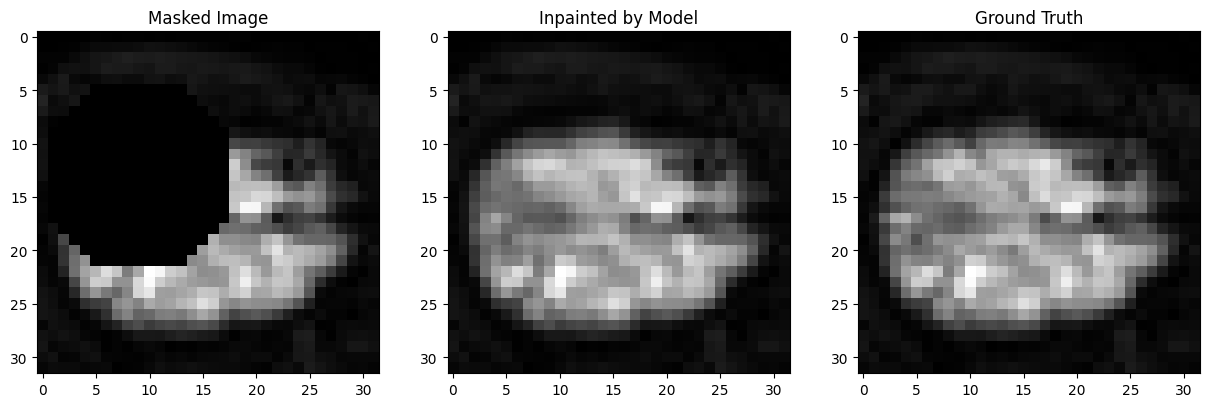

1/1 [==============================] - 0s 22ms/step


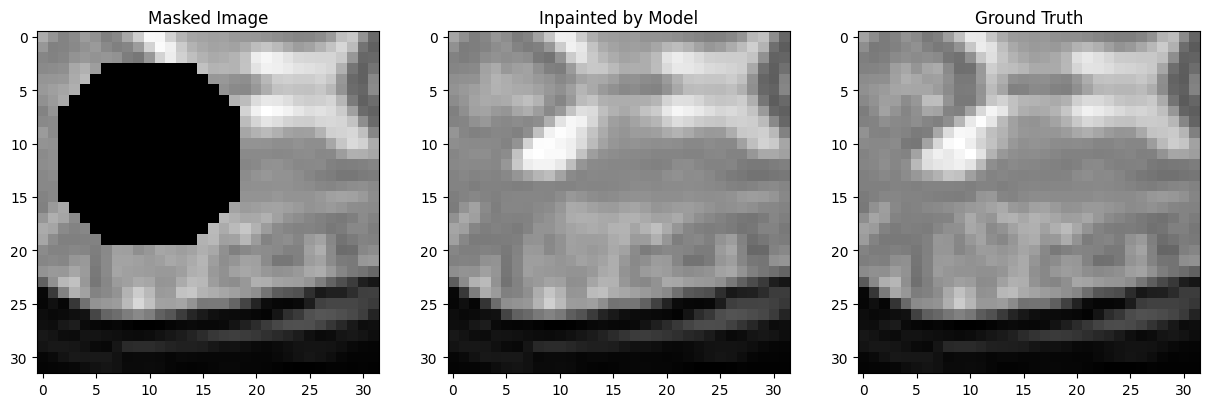

1/1 [==============================] - 0s 21ms/step


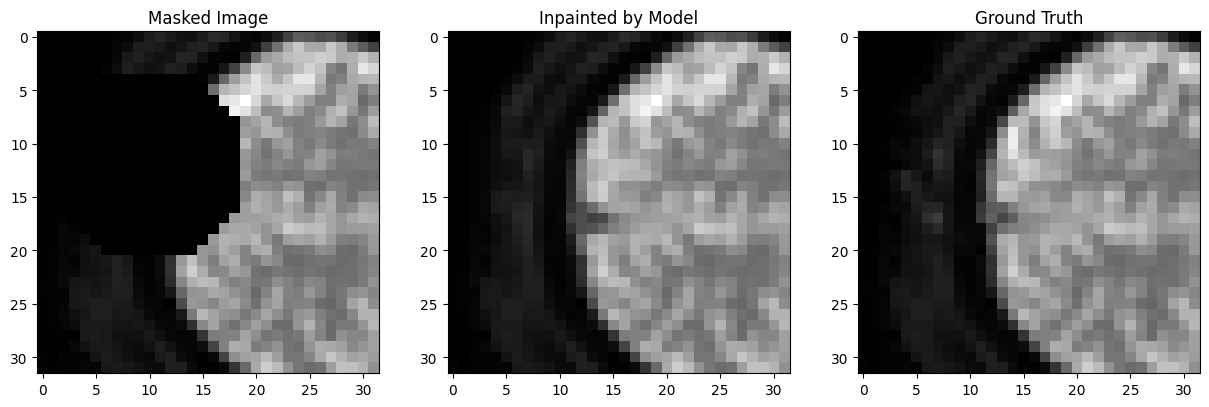

1/1 [==============================] - 0s 22ms/step


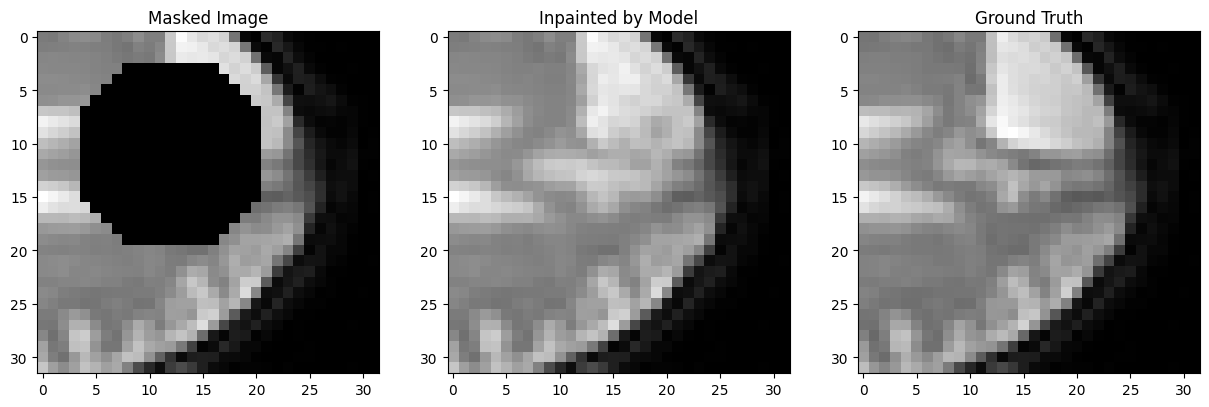

1/1 [==============================] - 0s 21ms/step


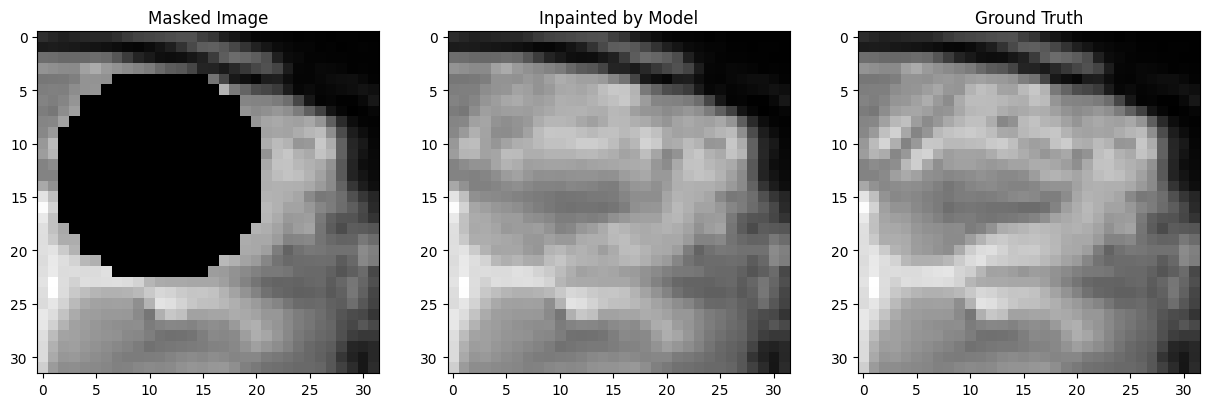

1/1 [==============================] - 0s 22ms/step


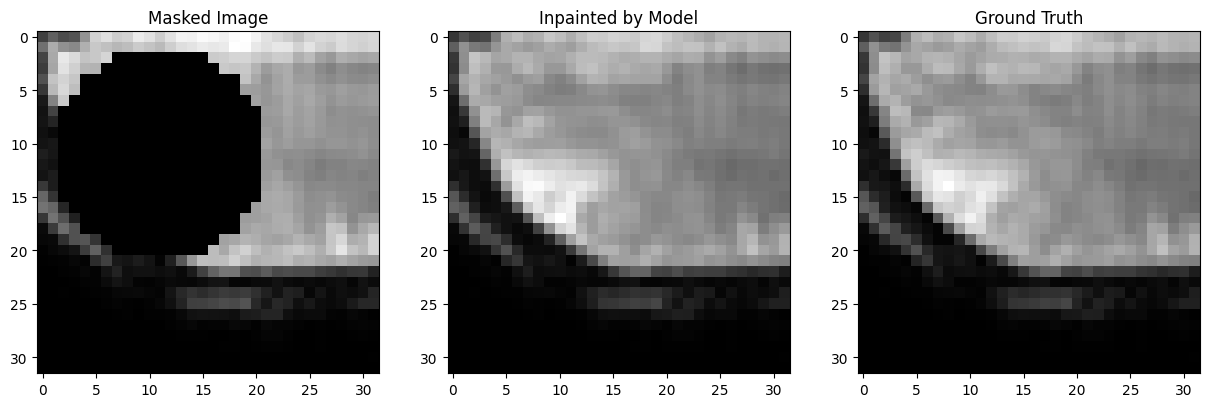

1/1 [==============================] - 0s 23ms/step


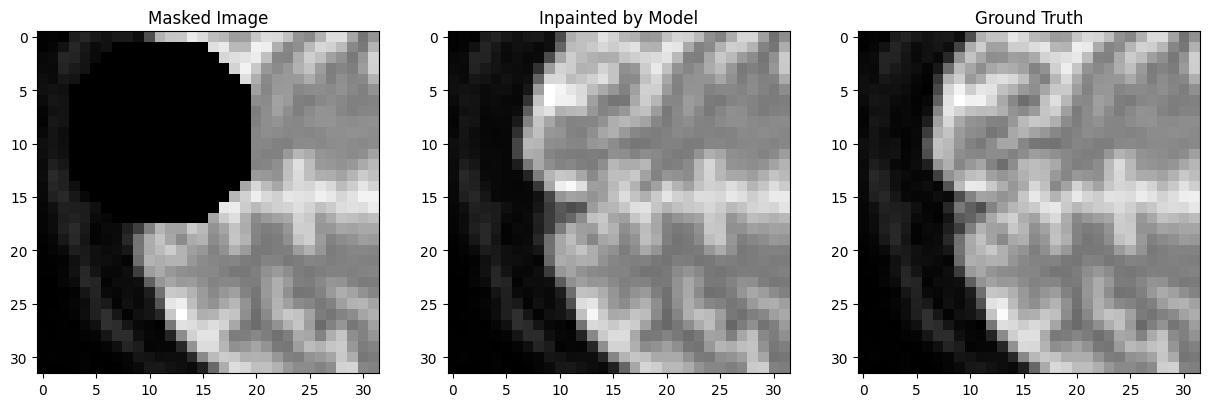

1/1 [==============================] - 0s 22ms/step


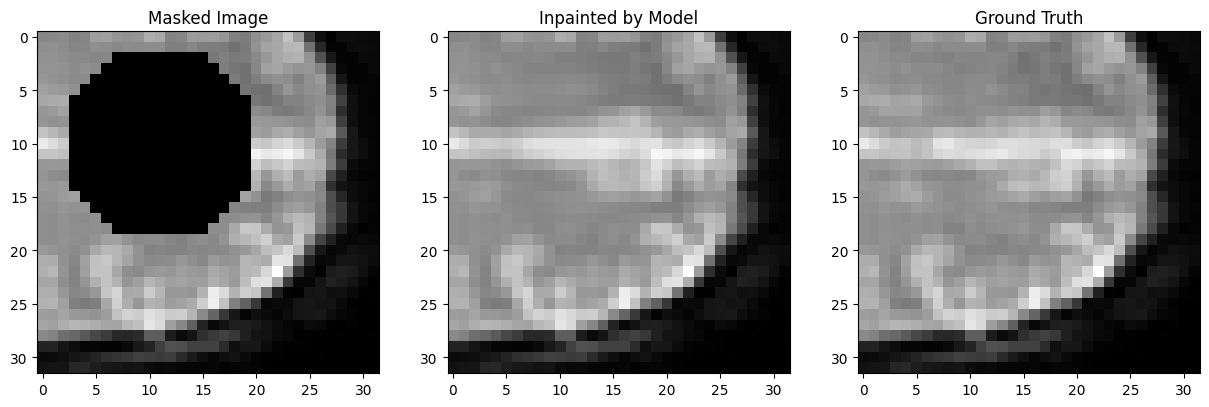

1/1 [==============================] - 0s 22ms/step


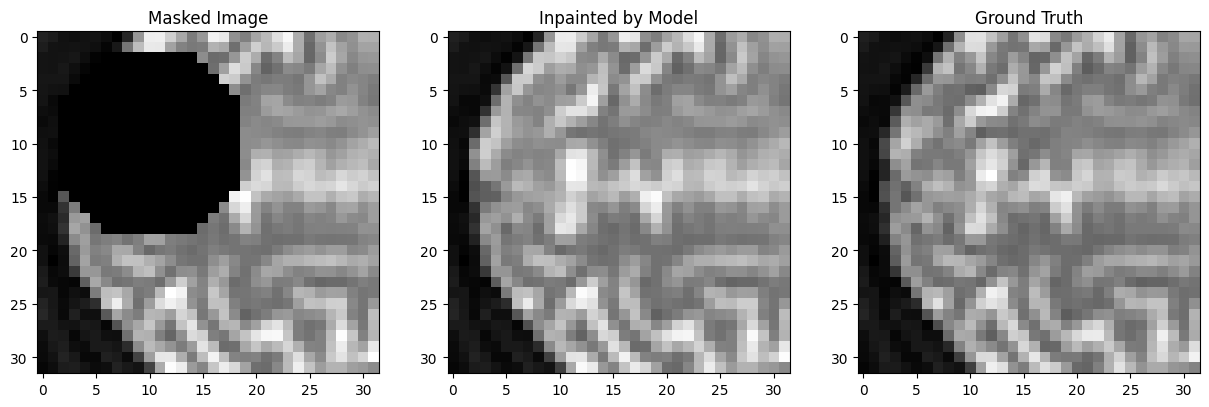

In [37]:
import matplotlib.pyplot as plt

np.random.seed(0)
num_images_to_show = 10

for i in range(num_images_to_show):
    img_index = np.random.randint(len(X_test))  # Use the length of your dataset

    masked_image = X_test[img_index]
    original_image = y_test[img_index]
    mask = masks_test[img_index]
    prediction = model6.predict([masked_image[np.newaxis, ...], original_image[np.newaxis, ...], mask[np.newaxis, ...]])[0]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(masked_image.squeeze(), cmap='gray')
    plt.title('Masked Image')

    plt.subplot(1, 3, 2)
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.title('Inpainted by Model')

    plt.subplot(1, 3, 3)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Ground Truth')

    plt.show()

##Combined loss funtion

In [38]:
import tensorflow as tf
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


def ssim_bce(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0)) + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred, labels=y_true))

def ssim_mse(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0)) + 10*tf.reduce_mean(tf.square(y_true - y_pred))  #set 1.0 here because the range of images is [0,1]



model7 = create_model()
optimizer = Adam(learning_rate=0.001)
model7.compile(optimizer=optimizer, loss=ssim_mse)


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model7.fit([X_train, y_train, masks_train], y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stop])


model7.evaluate([X_test, y_test,masks_test], y_test)

Epoch 1/50
214/214 [==============================] - 15s 59ms/step - loss: 0.2874 - val_loss: 1.2481
Epoch 2/50
214/214 [==============================] - 12s 56ms/step - loss: 0.2347 - val_loss: 1.0157
Epoch 3/50
214/214 [==============================] - 12s 56ms/step - loss: 0.2074 - val_loss: 0.4188
Epoch 4/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1842 - val_loss: 0.1952
Epoch 5/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1664 - val_loss: 0.1671
Epoch 6/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1514 - val_loss: 0.1673
Epoch 7/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1376 - val_loss: 0.1485
Epoch 8/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1229 - val_loss: 0.1365
Epoch 9/50
214/214 [==============================] - 12s 56ms/step - loss: 0.1093 - val_loss: 0.1243
Epoch 10/50
214/214 [==============================] - 12s 56ms/step - loss: 0.096

0.04773727431893349

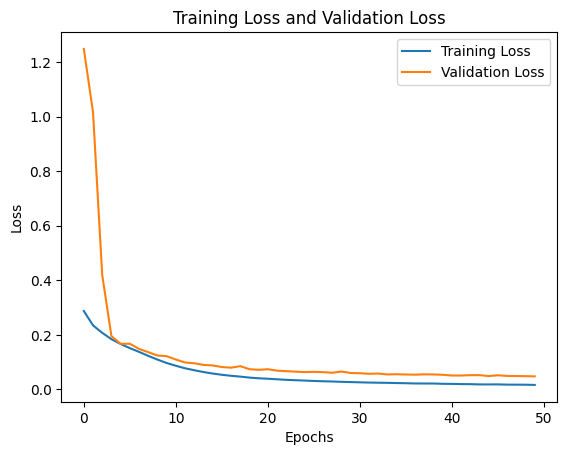

In [39]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0,0.01])
plt.legend()
plt.show()


1/1 [==============================] - 0s 22ms/step


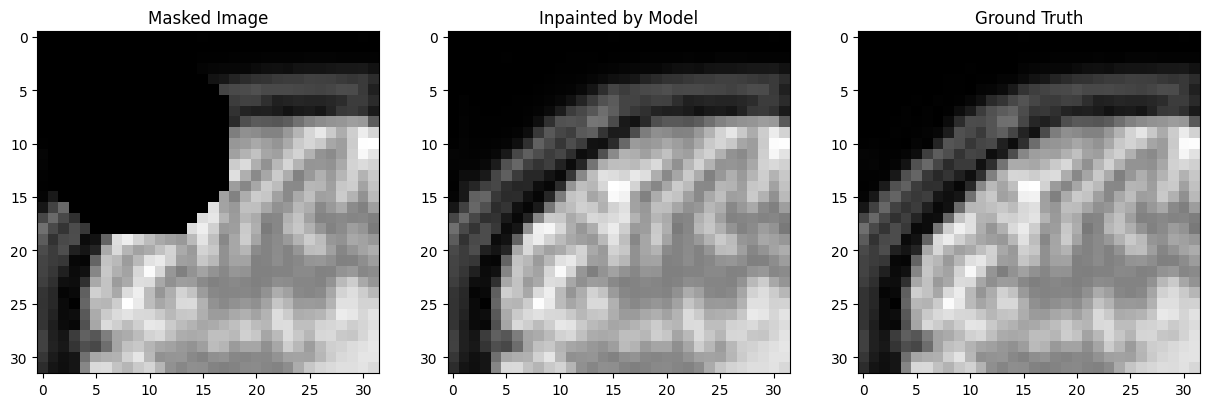

1/1 [==============================] - 0s 23ms/step


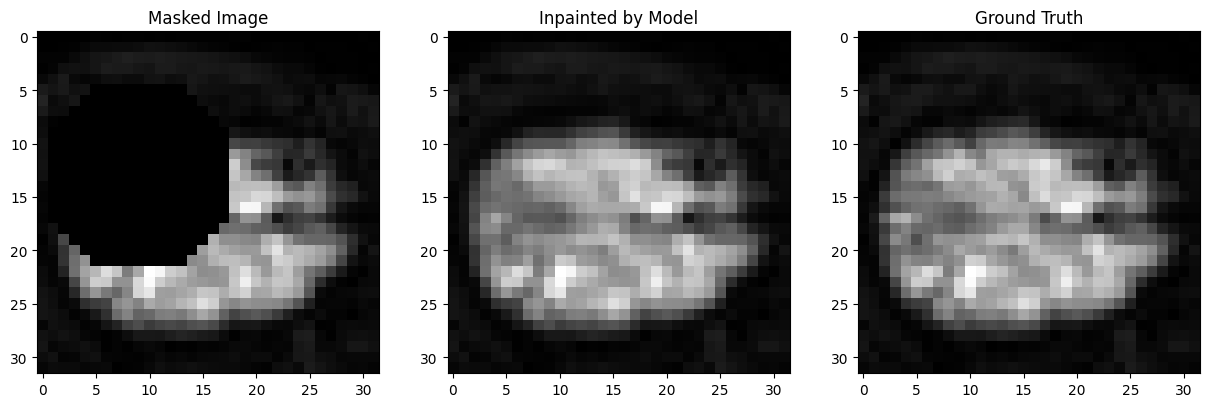

1/1 [==============================] - 0s 24ms/step


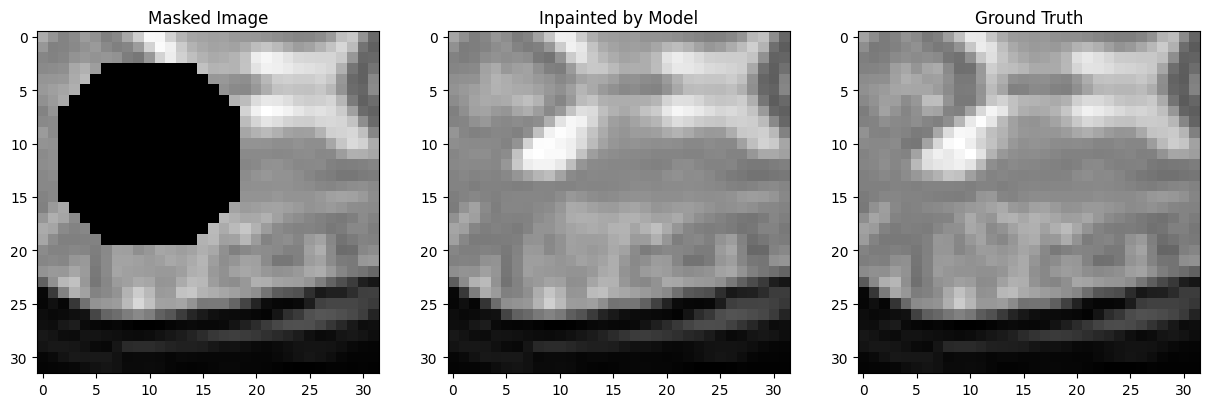

1/1 [==============================] - 0s 21ms/step


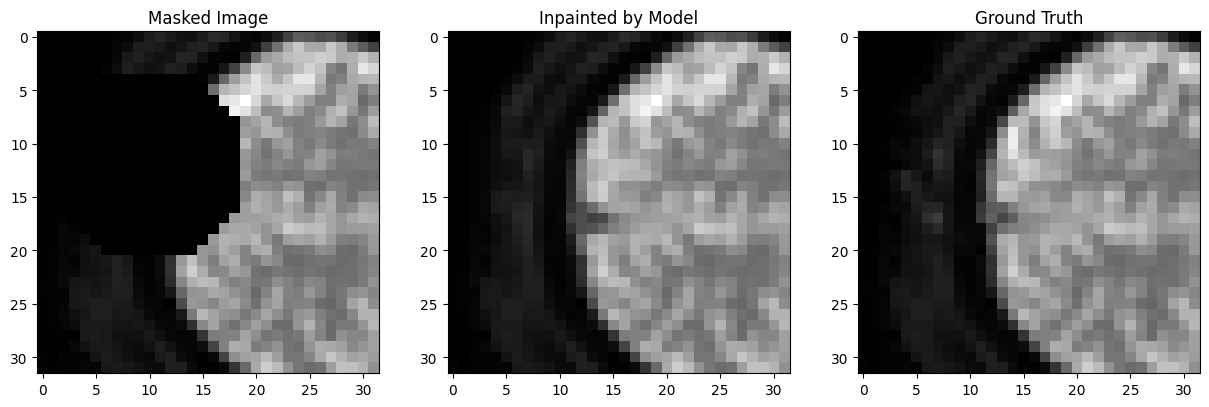

1/1 [==============================] - 0s 21ms/step


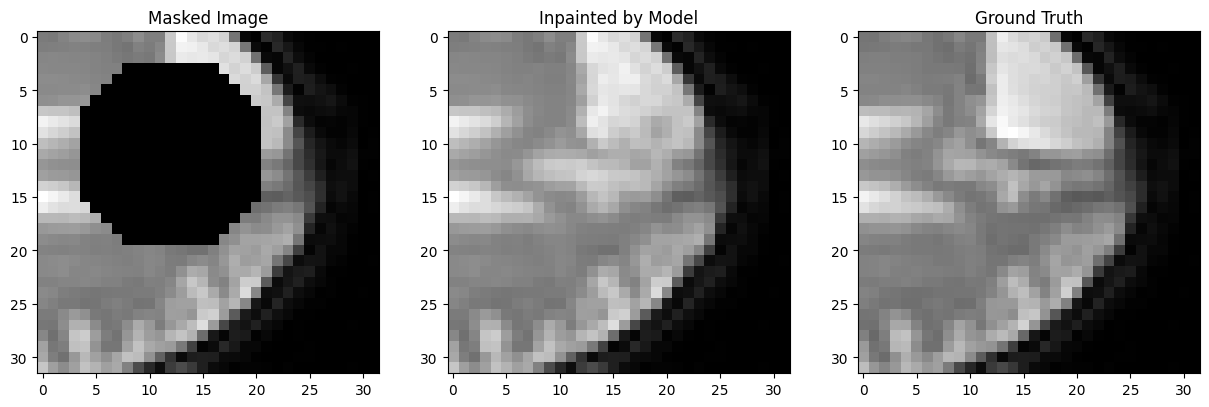

1/1 [==============================] - 0s 23ms/step


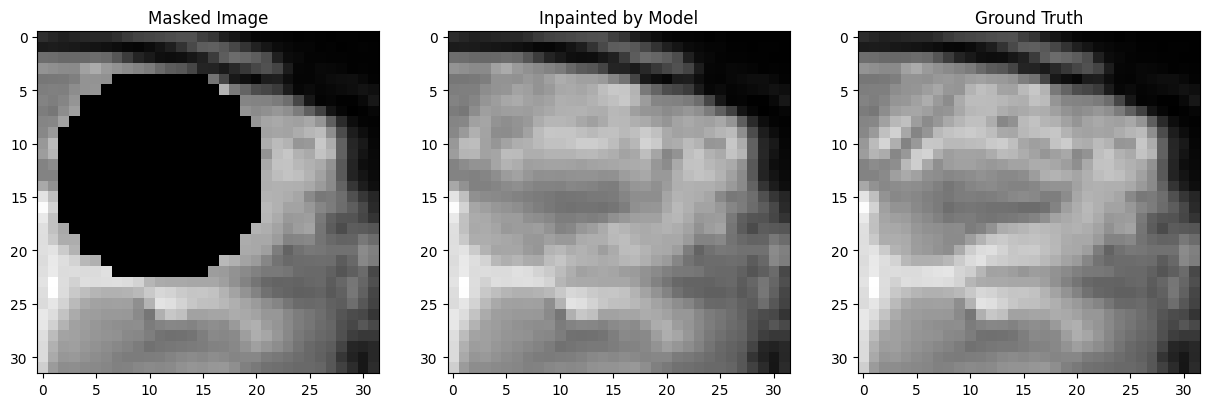

1/1 [==============================] - 0s 21ms/step


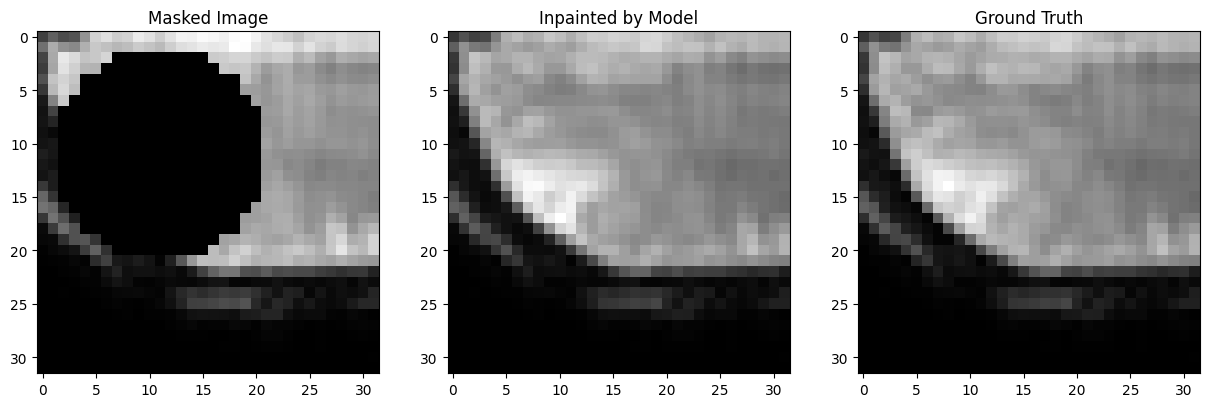

1/1 [==============================] - 0s 20ms/step


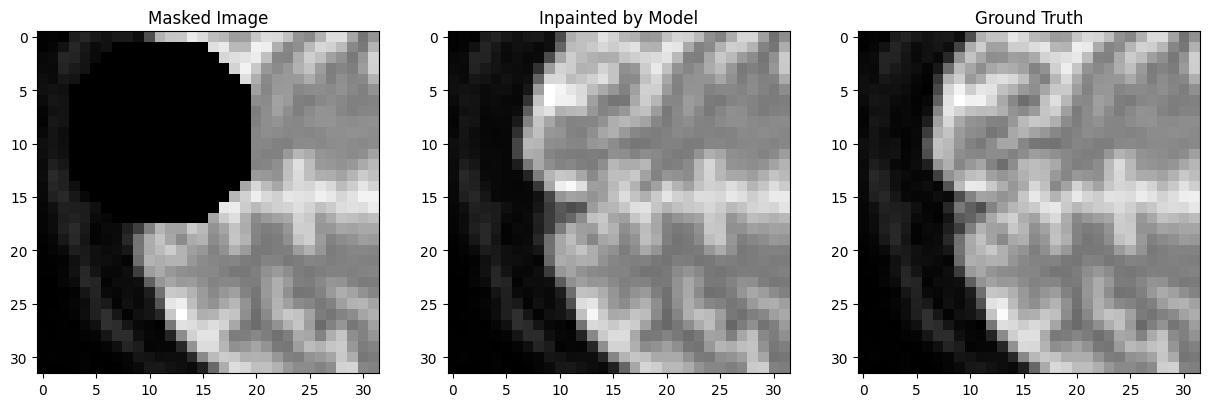

1/1 [==============================] - 0s 21ms/step


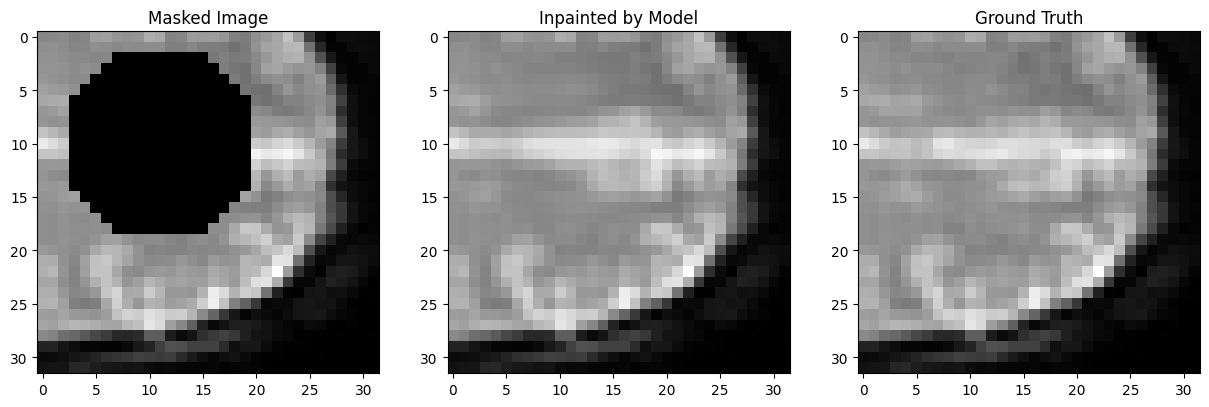

1/1 [==============================] - 0s 23ms/step


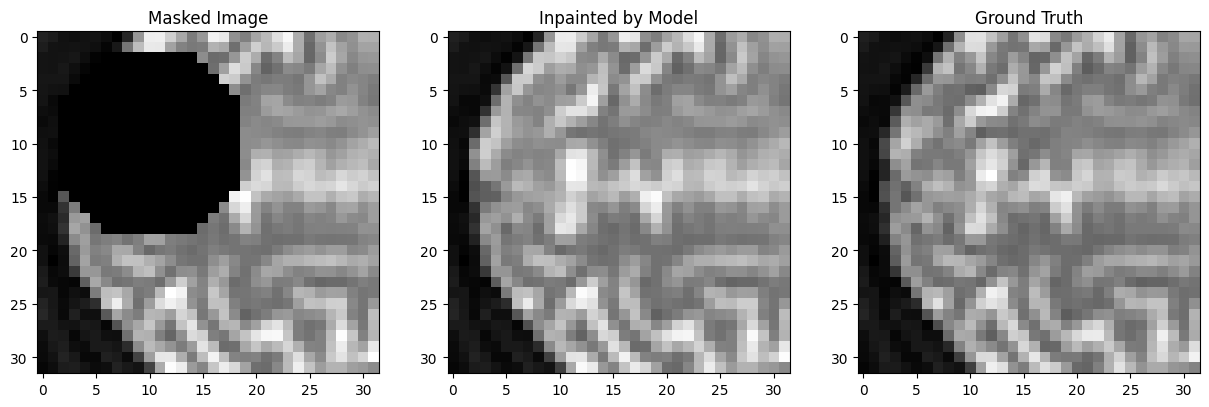

In [40]:
import matplotlib.pyplot as plt

np.random.seed(0)
num_images_to_show = 10

for i in range(num_images_to_show):
    img_index = np.random.randint(len(X_test))  # Use the length of your dataset

    masked_image = X_test[img_index]
    original_image = y_test[img_index]
    mask = masks_test[img_index]
    prediction = model6.predict([masked_image[np.newaxis, ...], original_image[np.newaxis, ...], mask[np.newaxis, ...]])[0]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(masked_image.squeeze(), cmap='gray')
    plt.title('Masked Image')

    plt.subplot(1, 3, 2)
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.title('Inpainted by Model')

    plt.subplot(1, 3, 3)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Ground Truth')

    plt.show()

# Overall result

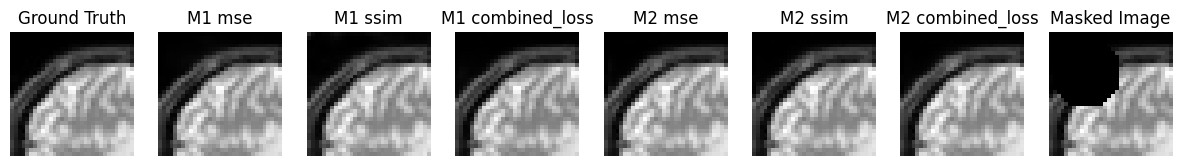

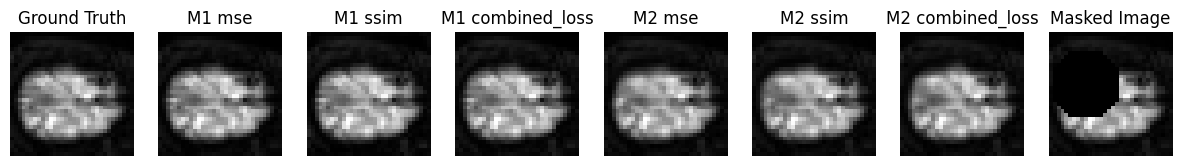

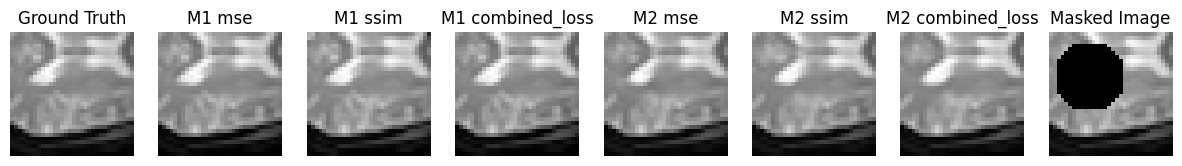

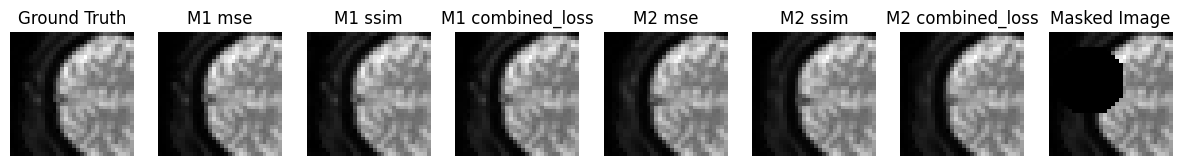

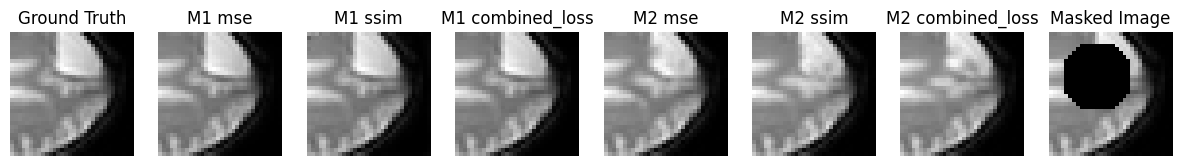

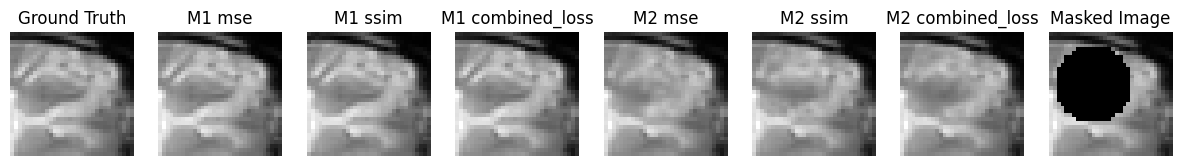

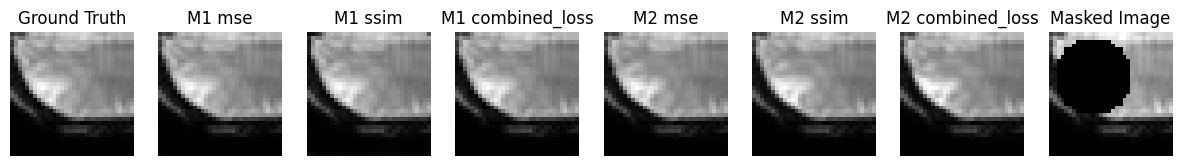

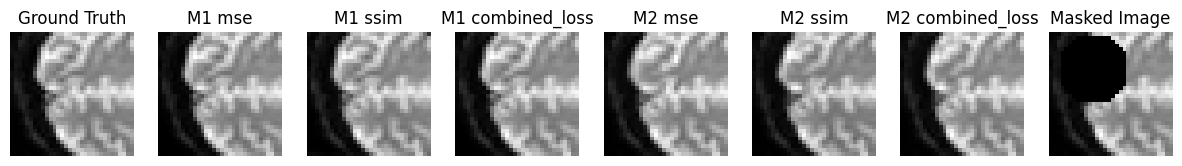

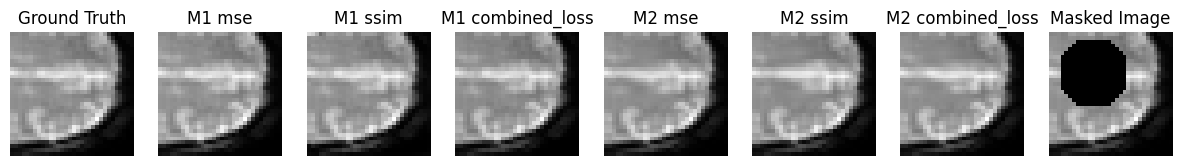

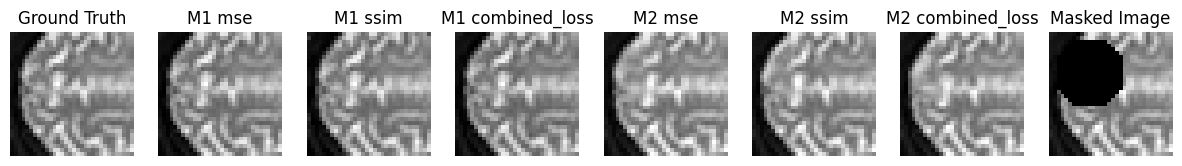

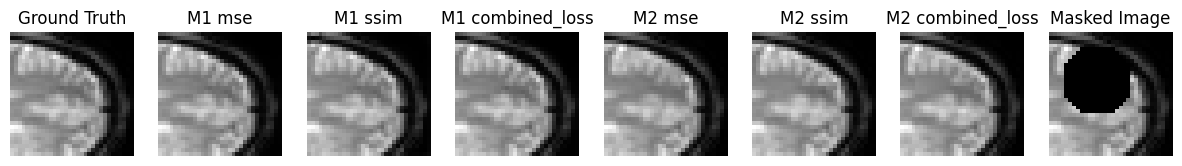

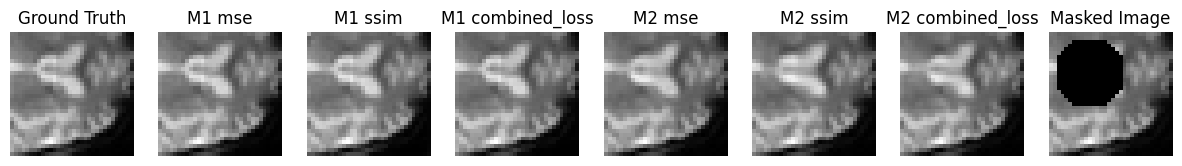

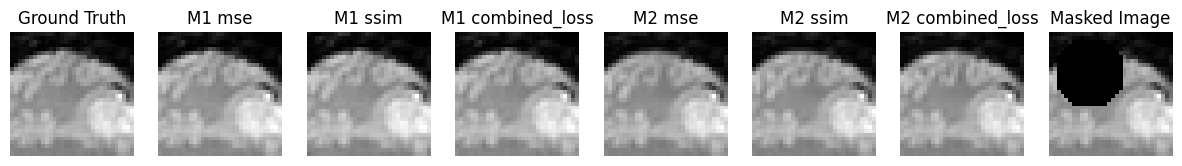

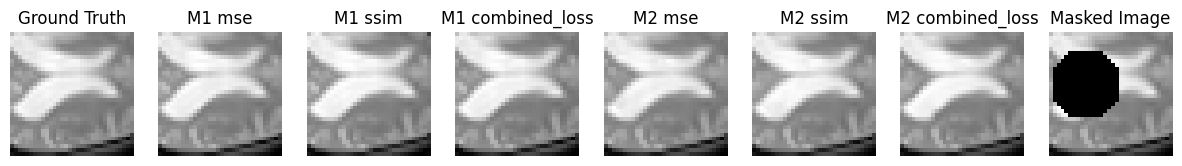

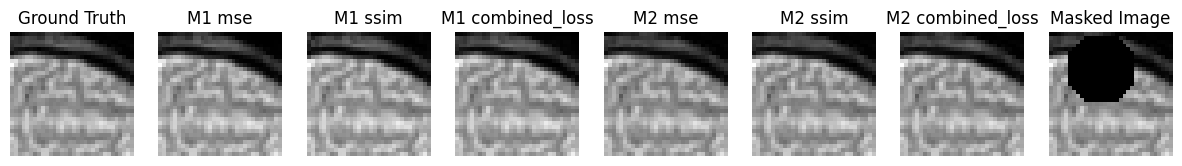

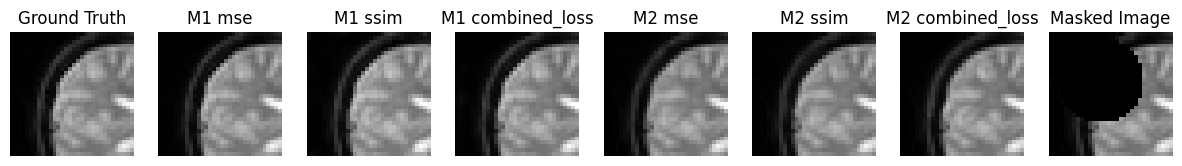

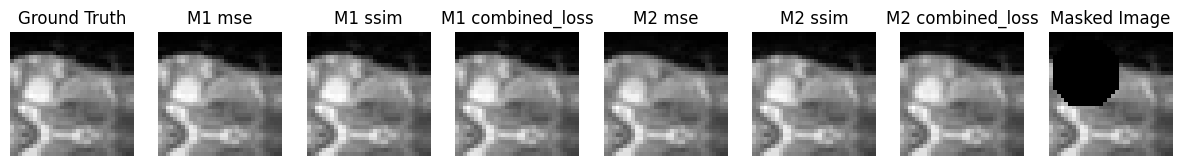

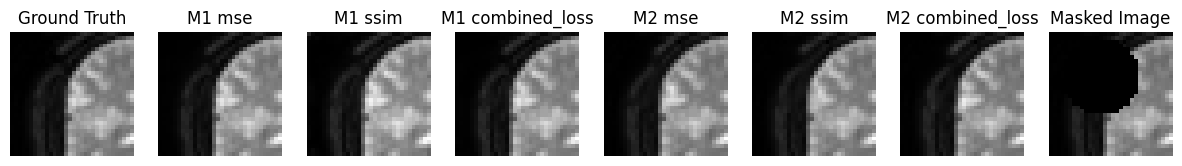

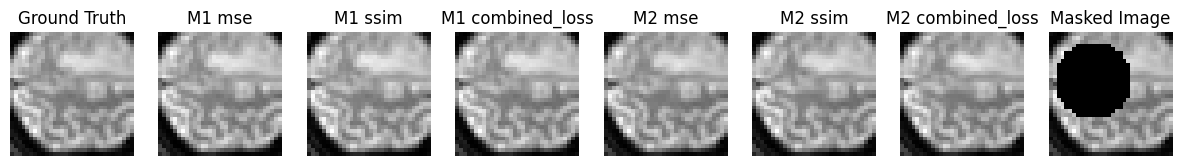

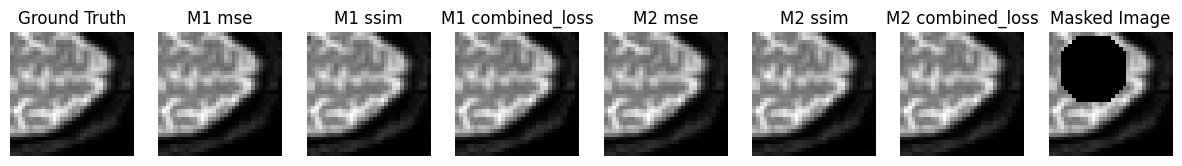

In [49]:
import matplotlib.pyplot as plt

np.random.seed(0)
num_images_to_show = 20

for i in range(num_images_to_show):
    img_index = np.random.randint(len(X_test))  # Use the length of your dataset
    masked_image = X_test[img_index]
    original_image = y_test[img_index]
    mask = masks_test[img_index]

    pred_1 = model1.predict(original_image[np.newaxis, ...], verbose=0)[0]
    pred_2 = model2.predict(original_image[np.newaxis, ...], verbose=0)[0]
    pred_3 = model3.predict(original_image[np.newaxis, ...], verbose=0)[0]
    pred_5 = model5.predict([masked_image[np.newaxis, ...], original_image[np.newaxis, ...], mask[np.newaxis, ...]], verbose=0)[0]
    pred_6 = model6.predict([masked_image[np.newaxis, ...], original_image[np.newaxis, ...], mask[np.newaxis, ...]], verbose=0)[0]
    pred_7 = model7.predict([masked_image[np.newaxis, ...], original_image[np.newaxis, ...], mask[np.newaxis, ...]], verbose=0)[0]

    plt.figure(figsize=(15, 10))

    plt.subplot(1, 8, 1)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 8, 2)
    plt.imshow(pred_1.squeeze(), cmap='gray')
    plt.title('M1 mse')
    plt.axis('off')

    plt.subplot(1, 8, 3)
    plt.imshow(pred_2.squeeze(), cmap='gray')
    plt.title('M1 ssim')
    plt.axis('off')

    plt.subplot(1, 8, 4)
    plt.imshow(pred_3.squeeze(), cmap='gray')
    plt.title('M1 combined_loss')
    plt.axis('off')

    plt.subplot(1, 8, 5)
    plt.imshow(pred_5.squeeze(), cmap='gray')
    plt.title('M2 mse')
    plt.axis('off')

    plt.subplot(1, 8, 6)
    plt.imshow(pred_6.squeeze(), cmap='gray')
    plt.title('M2 ssim')
    plt.axis('off')

    plt.subplot(1, 8, 7)
    plt.imshow(pred_7.squeeze(), cmap='gray')
    plt.title('M2 combined_loss')
    plt.axis('off')

    plt.subplot(1, 8, 8)
    plt.imshow(masked_image.squeeze(), cmap='gray')
    plt.title('Masked Image')
    plt.axis('off')

    plt.show()